## Linear regression

This assignment is dedicated to Linear regression. 12 task, 30 points max.

By focusing on predicting different features of football players,
you will:
* gain understanding of mathematics behind Linear Regression model
* and become familiar with using `sklearn` library for solving this kind of tasks

In the assignment we will:
* build Linear regression models with 1 and many variables
* use both library methods and manual calculations using mathematical formulas
* implement main regression metrics to evaluate performance of our models
* explore limitations of classical linear regression

### Notes:
* do not modify `assert` blocks in code. They are used to check your results
    

### Data
- In this notebook we will work with Football Player attributes per each match played.
  
  Data is taken from [European Soccer Database](https://www.kaggle.com/hugomathien/soccer) dataset. 
  
  The table used is `Player_Attributes`.


### Materias

Start with the assignment first. Use materials below as references when needed.

* NumPy:
    - [quickstart](https://numpy.org/doc/stable/user/quickstart.html)
    - [api reference](https://numpy.org/doc/stable/reference/index.html)
    

* Pandas:
    - [10 minutes to pandas](https://pandas.pydata.org/docs/user_guide/10min.html)
    - guide on [groupby.transform](https://pandas.pydata.org/docs/user_guide/groupby.html#transformation). 
      used in one of tasks on data preprocessing
    - [cheat sheet](https://pandas.pydata.org/Pandas_Cheat_Sheet.pdf)
    

* sklearn:
    - [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression) class documentation
    - guide on [Linear models](https://scikit-learn.org/stable/modules/linear_model.html#ordinary-least-squares)


* Matplotlib:
    - [cheatsheet](https://matplotlib.org/cheatsheets/)
    - examples of [main plot types](https://matplotlib.org/stable/plot_types/index.html)
    - [scatter plot](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html) documentation

In [777]:
import os

import numpy as np
import pandas as pd
pd.options.display.max_rows = 200
pd.options.display.max_columns = 100
pd.options.mode.chained_assignment = 'raise'  # forbid chained assignment to prevent implicit errors

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (7, 6)  # set default figure size

import seaborn as sns
sns.set(font_scale=1.1)  # increase default font scale and set seaborn's plot style

from typing import List, Iterable

## Data Processing

In [778]:
data_root_dp = os.path.join('D:\\', 'dev', 'rsschool-machine-learning-course', 'data', 'soccer')  # change to yours path
print(f'data_root_dp: "{data_root_dp}"')

data_root_dp: "D:\dev\rsschool-machine-learning-course\data\soccer"


### read the raw SQL data
* you can run this code only once.<br>
  it will read `.sqlite` file and save extracted data to a more handy `.csv` format

In [779]:
# import sqlite3

# # open connection to .sqlite file
# data_sql_fp = os.path.join(data_root_dp, 'database.sqlite')
# print(f'will read from: "{data_sql_fp}"')
# con = sqlite3.connect(data_sql_fp)

# df = pd.read_sql('select * from Player_Attributes', con)  # run SQL-query
# print(f'shape: {df.shape}')
# con.close()  # close connection to .sqlite file

# # save to .csv
# out_fp = os.path.join(data_root_dp, 'tmp', 'player_attributes.csv')
# os.makedirs(os.path.dirname(out_fp), exist_ok=True)  # create directories if needed
# print(f'will save to: "{out_fp}"')
# df.to_csv(out_fp, index=False)

### read the  data

In [780]:
data_player_attributes_fp = os.path.join(data_root_dp, 'player_attributes.csv')
print(f'reading from: "{data_player_attributes_fp}"')
df = pd.read_csv(data_player_attributes_fp)
print(df.shape)

reading from: "D:\dev\rsschool-machine-learning-course\data\soccer\player_attributes.csv"
(183978, 42)


In [781]:
df.dtypes

id                       int64
player_fifa_api_id       int64
player_api_id            int64
date                    object
overall_rating         float64
potential              float64
preferred_foot          object
attacking_work_rate     object
defensive_work_rate     object
crossing               float64
finishing              float64
heading_accuracy       float64
short_passing          float64
volleys                float64
dribbling              float64
curve                  float64
free_kick_accuracy     float64
long_passing           float64
ball_control           float64
acceleration           float64
sprint_speed           float64
agility                float64
reactions              float64
balance                float64
shot_power             float64
jumping                float64
stamina                float64
strength               float64
long_shots             float64
aggression             float64
interceptions          float64
positioning            float64
vision  

### basic data processing

In [782]:
# there are 3 'id' columns in data. 
# we will use 'player_api_id' only
# and drop other 'id' columns.
redundant_key_columns = ['id', 'player_fifa_api_id']

# also we will drop categorical columns for this task.
categorical_columns = ['preferred_foot', 'attacking_work_rate', 'defensive_work_rate']

cols_to_drop = redundant_key_columns + categorical_columns
print(f'will drop following columns: {cols_to_drop}')
df.drop(columns=cols_to_drop, inplace=True)

# rename 'player_api_id' column to shorter one: 'id'.
df.rename(columns={'player_api_id': 'id'}, inplace=True)

# cast string values to datetime
df['date'] = pd.to_datetime(df['date'])

# drop records that contain only NaNs in features
all_features = set(df.columns).difference(['id', 'date'])  # all columns without key columns
df.dropna(subset=all_features, how='all', inplace=True)

print(f'df.shape: {df.shape}')

will drop following columns: ['id', 'player_fifa_api_id', 'preferred_foot', 'attacking_work_rate', 'defensive_work_rate']
df.shape: (183142, 37)


In [783]:
# the dataset we're working with migh get updated in future (new records might be added).
# thus we remove any records with date larger than the current max date in data (2016-07-07)
# for compatibility with current version of notebook.
df.drop(index=df[df['date'] > '2016-07-07'].index, inplace=True)
print(df.shape)

(183142, 37)


### drop duplicates

* we should **ALWAYS** understand what our data represents


* here we are dealing with Football Player attributes per each match played.

  so we expect the data to have `(id, date)` as a key
  
  
* let's check whether our assumption holds

In [784]:
df.duplicated(['id', 'date']).value_counts()

False    183142
dtype: int64

* there are no duplicates if considering `(id, date)` pair as a key

In [785]:
df.duplicated('id').value_counts()

True     172082
False     11060
dtype: int64

* and there are duplicates if considering only `id` column as a key

* so our assumption holds. but let's work only with latest stats for each player

#### Task 1. Keep only latest data for each player (1 point)

* HINT: you can use 

  `df[<new_column>] = df.groupby(<key_to_aggregate>)[<column>].transform('max')` 
  
  to get the `max` value of `<column>` for each group specified by `<key_to_aggregate>` columns.
  
  then you'll have to filter rows using `<column>` and `<new_column>` values
  

* don't forget to remove any additional columns you introduce here

In [786]:
# leave only latest data for each player

df['max_date'] = df.groupby('id')['date'].transform('max')
df = df.drop(df[df['max_date'] != df['date']].index)

# drop max_date column that we created
df = df.drop('max_date', axis=1)
print(df.shape)

(11060, 37)


In [787]:
assert df.duplicated(['id']).sum() == 0
assert df.shape == (11060, 37)

In [788]:
# no longer need 'id' and 'date' columns
df.drop(columns=['id', 'date'], inplace=True)

**_Comment: we can also prove that there are no duplicated values in our dataset because in df.duplicated('id').value_counts() the shape was 11060_**

### NaNs

In [789]:
df.isna().sum()

overall_rating          0
potential               0
crossing                0
finishing               0
heading_accuracy        0
short_passing           0
volleys               478
dribbling               0
curve                 478
free_kick_accuracy      0
long_passing            0
ball_control            0
acceleration            0
sprint_speed            0
agility               478
reactions               0
balance               478
shot_power              0
jumping               478
stamina                 0
strength                0
long_shots              0
aggression              0
interceptions           0
positioning             0
vision                478
penalties               0
marking                 0
standing_tackle         0
sliding_tackle        478
gk_diving               0
gk_handling             0
gk_kicking              0
gk_positioning          0
gk_reflexes             0
dtype: int64

* do you see any pattern in how NaNs are distributed?

**_There are the same amount of missing values (478) in volleys, curve, agility and etc. May be there is a pattern that those missing values are in the same rows. In other words, we have 478 rows where all 7 features (volleys, curve, agility and etc.) are missing_**

In [790]:
df.isna().sum(axis=1).value_counts()

0    10582
7      478
dtype: int64

**_The line above underlines that my assumption is true. We have 478 rows that have 7 missing features_**

#### Task 2. Drop rows that contain NaNs (1 point)

In [791]:
df = df.dropna()

In [792]:
assert df.isna().sum().sum() == 0

## Task 3. Implement main regression metrics yourself (up to 4 points):
* Mean Squared Error (mse) - **(1 point)**
* Mean Absolute Error (mae) - **(1 point)**
* Mean Absolute Percentage Error (mape) - **(1 point)**
* R-squared (r2) - **(1 point)**


#### bonus point: MAPE is implemented in such way to take possible 0 in `y_true` into account
Hints:

* you should divide on 
  $ \hat{y}_{true} = (\hat{y}_{true}^{(0)}, \hat{y}_{true}^{(1)}, ..., \hat{y}_{true}^{(n)}) $,
  
  where $ \ \ \hat{y}_{true}^{(i)} = max(\ \ | y_{true}^{(i)} |, \ \ \epsilon), \ \ \epsilon > 0, \ \ y_{true}^{(i)} \in \mathbb R $
  

* for compatibility with `sklearn` take 

  `eps = np.finfo(np.float64).eps`
  
  
#### bonus point: $R^2$ is implemented in such way to take possible 0 in numerator and denominator into account
Hints:

* recall the formula: $ R^2 = 1 - \dfrac{SS_{residuals}}{SS_{total}} $


* you should return:

    $
    \begin{cases}
     R^2 & \text{ if } SS_{residuals} \ne 0 \text{ and  } SS_{total} \ne 0 
     \\
     0 & \text{ if } SS_{residuals} \ne 0 \text{ and  } SS_{total} = 0 
     \\
     1 & \text { otherwise }
    \end{cases}
    $
    

* for a better understanding of $R^2$ coefficient 
  try to explain to yourself why we return those values in each of edge cases

In [793]:
# we use '*' in the beggining of each function signature
# to forbid positional arguments and enforce the use of kwargs.
# this helps to avoid mistake when arguments are passed in wrong order.

# write down code instead of raising NotImplementedError in each of functions below.

def mse(*, y_true, y_pred):
    y_true = y_true.tolist()
    y_pred = y_pred.tolist()
    sum_error = 0.0
    for i in range(len(y_true)):
        sum_error += (y_pred[i] - y_true[i]) ** 2
    return sum_error / float(len(y_true))
    
def mae(*, y_true, y_pred):
    y_true = y_true.tolist()
    y_pred = y_pred.tolist()
    sum_error = 0.0
    for i in range(len(y_true)):
        sum_error += abs(y_pred[i] - y_true[i])
    return sum_error / float(len(y_true))

def mape(*, y_true, y_pred):
    y_divider = y_true.copy()
    eps = np.finfo(np.float64).eps
    y_divider[y_divider == 0] = eps
    mape = np.mean(np.abs((y_true - y_pred)/y_divider))
    return mape
    
def r2(*, y_true, y_pred):
    y_true = y_true.tolist()
    y_pred = y_pred.tolist()
    SS_res = 0.0
    for i in range(len(y_true)):
        SS_res += (y_pred[i] - y_true[i]) ** 2
    mean_y = np.mean(y_true)
    SS_tot = 0.0
    for i in range(len(y_true)):
        SS_tot += (y_true[i] - mean_y)**2
    if (SS_res != 0) and (SS_tot != 0):
        return (1 - (SS_res/SS_tot))
    elif (SS_res != 0) and (SS_tot == 0):
        return 0
    else:
        return 1

### Validate your implementations are correct

* we'll use synthetic data for this task


In [794]:
from sklearn.metrics import (
    mean_squared_error as mse_lib, 
    mean_absolute_error as mae_lib,
    mean_absolute_percentage_error as mape_lib,
    r2_score as r2_lib
)

In [795]:
def compare_metrics(fn, fn_lib, y_true, y_pred, n_digits=9):
    """ Print and compare values of custom and library functions using given precision. """
    m_fn = fn(y_true=y_true, y_pred=y_pred)
    m_fn_lib = fn_lib(y_true=y_true, y_pred=y_pred)
    print(f'{fn.__name__} custom : {m_fn}')
    print(f'{fn.__name__} library: {m_fn_lib}')
    print()
    assert round(m_fn, n_digits) == round(m_fn_lib, n_digits)

#### a case with a good fit

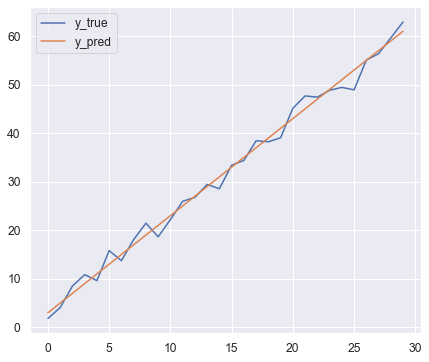

In [796]:
n = 30
x = np.arange(n)
y_true = 2 * x + 3 + np.random.normal(loc=0, scale=2, size=n)
y_pred = 2 * x + 3

plt.plot(x, y_true, label='y_true')
plt.plot(x, y_pred, label='y_pred')
plt.legend();

In [797]:
compare_metrics(mse, mse_lib, y_true=y_true, y_pred=y_pred)
compare_metrics(mae, mae_lib, y_true=y_true, y_pred=y_pred)
compare_metrics(mape, mape_lib, y_true=y_true, y_pred=y_pred)
compare_metrics(r2, r2_lib, y_true=y_true, y_pred=y_pred)
print('all tests passed')

mse custom : 2.7458063505318573
mse library: 2.7458063505318573

mae custom : 1.371105072710694
mae library: 1.371105072710694

mape custom : 0.08474048083087676
mape library: 0.08474048083087676

r2 custom : 0.9908058306615151
r2 library: 0.9908058306615151

all tests passed


#### 0s in target. MAPE should explode

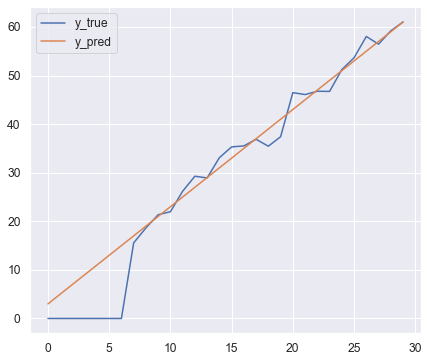

In [798]:
n = 30
x = np.arange(n)
y_true = 2 * x + 3 + np.random.normal(loc=0, scale=2, size=n)
y_true[:7] = 0
y_pred = 2 * x + 3

plt.plot(x, y_true, label='y_true')
plt.plot(x, y_pred, label='y_pred')
plt.legend();

In [799]:
compare_metrics(mse, mse_lib, y_true=y_true, y_pred=y_pred)
compare_metrics(mae, mae_lib, y_true=y_true, y_pred=y_pred)
compare_metrics(mape, mape_lib, y_true=y_true, y_pred=y_pred)
compare_metrics(r2, r2_lib, y_true=y_true, y_pred=y_pred)
print('all tests passed')

mse custom : 25.098377028240826
mse library: 25.09837702824084

mae custom : 3.1218641626531327
mae library: 3.1218641626531336

mape custom : 9457559217478042.0
mape library: 9457559217478042.0

r2 custom : 0.9392478962078192
r2 library: 0.9392478962078191

all tests passed


#### edge cases for R2

In [800]:
# constant target value

n = 30
x = np.arange(n)
y_true = np.repeat(15, n)
y_pred = 2 * x + 3

compare_metrics(r2, r2_lib, y_true=y_true, y_pred=y_pred)
print('success')

r2 custom : 0
r2 library: 0.0

success


In [801]:
# perfect fit

n = 30
x = np.arange(n)
y_true = 2 * x + 3 + np.random.normal(loc=0, scale=2, size=n)
y_pred = y_true

compare_metrics(r2, r2_lib, y_true=y_true, y_pred=y_pred)
print('success')

r2 custom : 1
r2 library: 1.0

success


### Define helper functions

In [802]:
def get_metrics(*, y_true, y_pred) -> pd.Series:
    """ A helper function to return all metrics for given labels and predictions. """
    
    # if you didn't implement some metrics, comment them out for this function to work.
    return pd.Series({
        'mse': mse(y_true=y_true, y_pred=y_pred),
        'mae': mae(y_true=y_true, y_pred=y_pred),
        'mape': mape(y_true=y_true, y_pred=y_pred),
        'r2': r2(y_true=y_true, y_pred=y_pred),
    })

In [803]:
def fit_and_evaluate(model, x_train, y_train, x_test, y_test) -> pd.DataFrame:
    """ 
    A helper function to: 
    * fit a passed model
    * and return metrics on train and test sets.
    """
    # fit the model
    model.fit(x_train, y_train)
    
    # return metrics as pd.DataFrame
    m = pd.DataFrame([
        get_metrics(y_true=y_train, y_pred=model.predict(x_train)),  # metrics for train set
        get_metrics(y_true=y_test, y_pred=model.predict(x_test))     # metrics for test set
    ], index=['train', 'test']
    )
    
    return m

## train/test split

* Split the data we have into Train and Test splits with 80%/20% proportion

In [804]:
print(df.shape)
ix_split = int(0.8 * df.shape[0])
DF_TRAIN = df.iloc[:ix_split].copy()
DF_TEST = df.iloc[ix_split:].copy()
print(DF_TRAIN.shape, DF_TEST.shape)

(10582, 35)
(8465, 35) (2117, 35)


In [805]:
def get_train_test_data(features: List[str], target: str) -> tuple:
    """
    Return x_train, y_train, x_test, y_test using 
    * global train/test split 
    * features and target provided.
    """
    # in general, it's a bad practice to use global variables. 
    # however, we use it here with caution for simplicity.
    return (
        DF_TRAIN[features].copy(), DF_TRAIN[target].copy(), 
        DF_TEST[features].copy(), DF_TEST[target].copy()
    )

## Linear regression with 1 variable

* Let's start with Linear Regression that predicts target variable 
  using only 1 predictor (independent variable)  

* We will try to predict `dribbling` variable using `short_passing` as a predictor

In [806]:
target = 'dribbling'
features = ['short_passing']
x_train, y_train, x_test, y_test = get_train_test_data(features, target)

### Let's visualize our data first

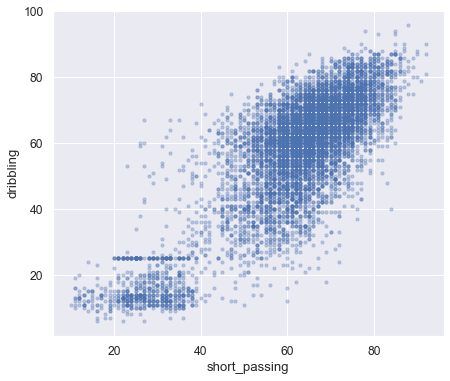

In [807]:
plt.scatter(x=x_train, y=y_train, alpha=0.3, s=10);
plt.xlabel('short_passing');
plt.ylabel('dribbling');

* do you notice anything interesting on this plot?
* if so, how can we use it later to generate more accurate predictions?

**_COMMENT about Interesting:_** 
- It seems that there a linear line that we can draw through the dataset
- It is a linear correlation between short_passing and dribbling
- This is an increasing linear function
- The equation of the function is around y = x - 10
- There is a gap in values between 40 < short_passing < 45
![Linear correlation](pattern_in_data_linear_regression.png)

**_Our correlation is close to linear, so we can use it to generate predictions using Linear Regression_**

### Task 4. Compute Pearson correlation coefficient between feature and target (1 pont)
Hint: you can use either `pd.Series.corr` method or `np.corrcoef` function

In [808]:
correlation = df.dribbling.corr(df.short_passing , method="pearson")
correlation

0.8129375578604557

**_Correlation is between 2 features short_passing and dribbling is high_**

### Solve using `sklearn`

* we will use `LinearRegression` class from `sklearn` library 
  to fit a linear regression model and use it to generate prediction

In [809]:
from sklearn.linear_model import LinearRegression

In [810]:
model = LinearRegression(fit_intercept=True)
model.fit(x_train, y_train);

* explore fitted model parameters

In [811]:
model_intercept = model.intercept_
model_slope = model.coef_[0]
print(f'model_intercept: {model_intercept}')
print(f'model_slope: {model_slope}')

model_intercept: -6.211029905026031
model_slope: 1.0366141627766248


* use fitted model to get predictions for test set

In [812]:
model_preds = model.predict(x_test)
model_preds

array([55.98581986, 65.31534733, 44.58306407, ..., 62.20550484,
       54.9492057 , 76.71810312])

* explore model quality on test set.

In [813]:
print('model metrics on test set')
metrics_test_1 = get_metrics(y_true=y_test, y_pred=model_preds)
metrics_test_1

model metrics on test set


mse     108.345801
mae       8.173553
mape      0.205500
r2        0.681477
dtype: float64

* can you explain what those metic values mean?

**_What metrics mean_**


- **MSE** “Mean squared error” essentially finds the average squared error between the predicted and actual values. The lower the value the better and 0 means the model is perfect
Consequently, we cannot say whether the value 108 above is good or bad, but it is better to try to minimize it.
!['MSE formula'](mse_formula.png)

- **MAE** Mean absolute error (or mean absolute deviation) is another metric which finds the average absolute distance between the predicted and target values.
MAE is known to be more robust to the outliers than MSE. The main reason being that in MSE by squaring the errors, the outliers (which usually have higher errors than other samples) get more attention and dominance in the final error and impacting the model parameters.
As with MSE in MAE there is no correct value. Consequently, we cannot say whether the value 8 above is good or bad, but it is better to try to minimize it.
!['MAE formula'](mae_formula.png)

- **MAPE** mean absolute percentage error, shows percentage of a difference between the predicted value and actual value. For example, in the case above its 20%.
!['MAPE formula'](mape_formula.png)

- **R2** indicates the percentage of the variance in the dependent variable that the independent variables explain collectively, measures the strength of the relationship between your model and the dependent variable on a 0 – 100% scale. Usually, the larger the R2, the better the regression model fits your observations. For example, in the case above R2 is 68%.
!['R2 formula'](r2_formula.png)

#### Task 5. Calculate predictions for test set manually (1 point)

Above we used `LinearRegression.predict()` method to obtain predictions. 
Now let's do it manually!

Recall Linear Regression formula:

* $ \hat{y} = w_0 + w_1 \cdot x, $ 

    where:
    * $w_0$ is an intercept
    * $w_1$ is a slope
    * $x$ is a predictor
    * $\hat{y}$ is a predicted variable
  

* use intercept and slope values from fitted LinearRegression model

In [814]:
# use `x_test` for calculations as is (it's a DataFrame with 1 column).
# do not convert it to Series or numpy array.

# your code here:
model_manual_preds = model_slope * x_test + model_intercept

**_We created a linear function_**

In [815]:
assert isinstance(model_manual_preds, pd.DataFrame)

In [816]:
# ensure our manual predictions are the same as model generated
assert np.allclose(model_preds, model_manual_preds.iloc[:, 0].to_numpy())
print('success')

success


#### Task 6. Plot test data and predicted values (1 point)

* use `plt.scatter` function as in example above.
* first build scatter plot for test data
* then build scatter plot with model predictions
* add plot title, axis names and legend

Hints:
* use `alpha` parameter to control opacity and `s` parameter to control size of points.
  this will make plot more readable
* use `label` parameter to add label to each set of points added to scatter plot
* use different color for model predictions. control with parameter `color`

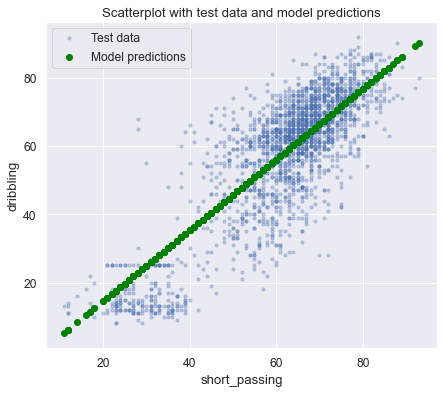

In [817]:
# # your code here
plt.scatter(x=x_test, y=y_test, alpha=0.3, s=10)
plt.scatter(x=x_test, y=model_preds, color='green')
plt.xlabel('short_passing')
plt.ylabel('dribbling')
plt.title('Scatterplot with test data and model predictions')
plt.legend(['Test data', 'Model predictions']);

**_We plotted a simple linear regression_**

### Task 7.  Fit regression model manually (3 points)

So far we have used `sklearn` library to fit linear regression model and obtain predictions. Good job!

Recall the formula of Linear regression for 1 variable:

* $ \hat{y} = w_0 + w_1 \cdot x $

Now let's try to fit the model **ourselves**.

### Theory

Assume our dataset consists of _n_ samples.

To fit a Linear regression model means to find the best set of parameters - 
$(w_0, w_1)$ that minimizes a **Loss function**.<br>
In case of Linear regression we choose **Residual sum of squares (RSS)** as a Loss function:

* $ L(w, x, y) = RSS(w, x, y) = \sum_{i=0}^{n-1} (y_i - \hat{y}_i ) ^ 2 \rightarrow min $

That is conceptually the same as minimizing Mean squared error (MSE):

* $ MSE(w, x, y) = \dfrac{1}{n} \sum_{i=0}^{n-1} (y_i - \hat{y}_i ) ^ 2 \rightarrow min $

Here:
* $y = (y_0, y_2, ..., y_{n-1}) $ - is a vector of target values we want to predict.
  1 value per each sample in our dataset that consists of _n_ samples
* $\hat{y} = (\hat{y}_0, \hat{y}_2, ..., \hat{y}_{n-1}) $ - is a vector of predictions 
* $\hat{y}_i = w_0 + w_1 \cdot x_i$ - is an individual prediction for _i_-th sample in a dataset

---

Best parameters $w_0$ and $w_1$ can be found using **following formulas**:

* $w_0 = \bar{y} - w_1 \cdot \bar{x}$


* $w_1 = \dfrac{\sum_{i=0}^{n-1}(x_i - \bar{x}) y_i}{\sum_{i=0}^{n-1}(x_i - \bar{x})^2}$


* where:
 * $\bar{x} = \dfrac{1}{n} \sum_{i=0}^{n-1}x_i$ - is the mean of vector $x$
 
 * $\bar{y} = \dfrac{1}{n} \sum_{i=0}^{n-1}y_i$ - is the mean of vector $y$
 
You should use these formulas to find the best model parameters in this task.
 
---

If you want to learn more you can refer to 
[Simple linear regression](https://en.wikipedia.org/wiki/Simple_linear_regression) wiki-page.

It contains analagous formula for $w_1$ coefficient that is conceptually the same 
(so it's not a bug in our formula provided above).

### Implementation

* convert pd.DataFrame and pd.Series (`x_train` and `y_train` respecitvely) to numpy-arrays

In [818]:
x = x_train.iloc[:, 0].to_numpy()
y = y_train.to_numpy()

* calculate model parameters ($w_1$ - slope and $w_0$ - intercept) using formulas given above

In [819]:
# # your code here:
manual_slope = ((x - x.mean()) * y).sum() / ((x - x.mean())**2).sum()
manual_intercept = y.mean() - manual_slope * x.mean()

In [820]:
print(f'manual_intercept: {manual_intercept}')
print(f'manual_slope: {manual_slope}')

manual_intercept: -6.211029905026017
manual_slope: 1.0366141627766245


In [821]:
assert round(model_intercept, 9) == round(manual_intercept, 9)
assert round(model_slope, 9) == round(manual_slope, 9)
print('success')

success


**_Our calculated manually intercept and slope are the same as in pre-built model_**

## Linear regression with multiple variables

* Now let's use Linear Regression model that uses multiple variables

* We will try to predict `dribbling` variable using 
  `['ball_control', 'short_passing', 'strength', 'sprint_speed']` features

In [822]:
target = 'dribbling'
features = ['ball_control', 'short_passing', 'strength', 'sprint_speed']
x_train, y_train, x_test, y_test = get_train_test_data(features, target)

### Let's explore the data first

In [823]:
cols = features + [target]
print(cols)

['ball_control', 'short_passing', 'strength', 'sprint_speed', 'dribbling']


#### Task 8 (1 point)

Build pairwise correlation matrix for selected features and target. Visualize it with heatmap.

Hints:
* use `DF_TRAIN` to build statistics (`x_train` contains only features. target is in `y_train`)
* use `pd.DataFrame.corr()` to build correlation matrix
* use `sns.heatmap` to build heatmap from correlation matrix. 
  * use `center` parameter to center your heatmap's colormap at 0
  * use diverging colormap (`cmap` parameter)<br>
    you can find the list of diverging colormaps
    [here](https://matplotlib.org/stable/tutorials/colors/colormaps.html#diverging)<br>
    the reason is that we need to easily find both negative and positive correlations.
  * use `annot` parameters to add numbers to the plot.
* you can print `pd.DataFrame` and build plot in the same cell.<br> 
  use `display(...)` function that accets `pd.DataFrame` before building the plot
  
You can refer to [seaborn.heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html) documentation

ball_control  short_passing  strength  sprint_speed  dribbling
ball_control       1.000000       0.826278 -0.099919      0.497385   0.886144
short_passing      0.826278       1.000000 -0.013008      0.319036   0.690062
strength          -0.099919      -0.013008  1.000000     -0.219997  -0.230438
sprint_speed       0.497385       0.319036 -0.219997      1.000000   0.634323
dribbling          0.886144       0.690062 -0.230438      0.634323   1.000000

<AxesSubplot:>

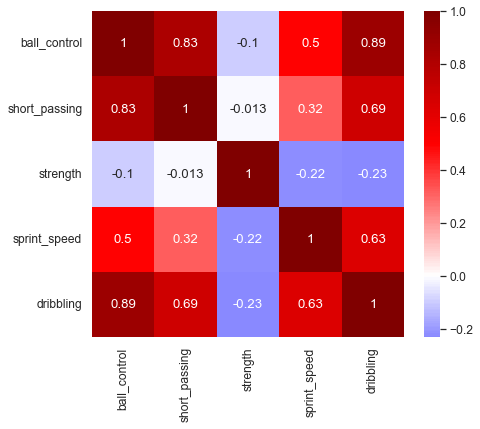

In [824]:
# # your code here
correlation_matrix = DF_TRAIN[cols].corr(method='spearman')
display(correlation_matrix)

sns.heatmap(data=correlation_matrix, center=0, cmap='seismic', annot=True)

* what can you say about selected feature set using this correlation matrix?

**_I can say that we have certain correlations between our selected features:_**


1. Very strong 0.9-1:
    No
2. Strong 0.7 - 0.9:
    - short_passing and ball_control
    - dribbling and ball_control
3. 0.5 - 0.7 mild correlation:
    - dribbling and short_passing
    - dribbling and sprint_speed
4. Weak 0.3 - 0.5:
    - sprint_speed and ball_control
    - sprint_speed and short_passing
5. Very weak 0 - 0.3:
    - strength and ball_control
    - strength and short_passing
    - sprint_speed and strength
    - dribbling and strength

**_Using those correlations we can better select features for our model._**

#### Let's build pairplots for features and target

* `plot_kws` parameter accepts dictionary of keyword arguments 
  that are passed to bivariate plotting function (`sns.scatterplot` in this case)


* we set size to 7 (using `s` parameter) to make points smaller and see patterns clearly.<br>
  you can compare this to running with not `plot_kws` passed.
  

* `alpha` parameter also helps to see data distribution clearly


* you can also experiment with `kind` parameter - refer to
  [seaborn.pairplot](https://seaborn.pydata.org/generated/seaborn.pairplot.html)
  documentation for possible values.

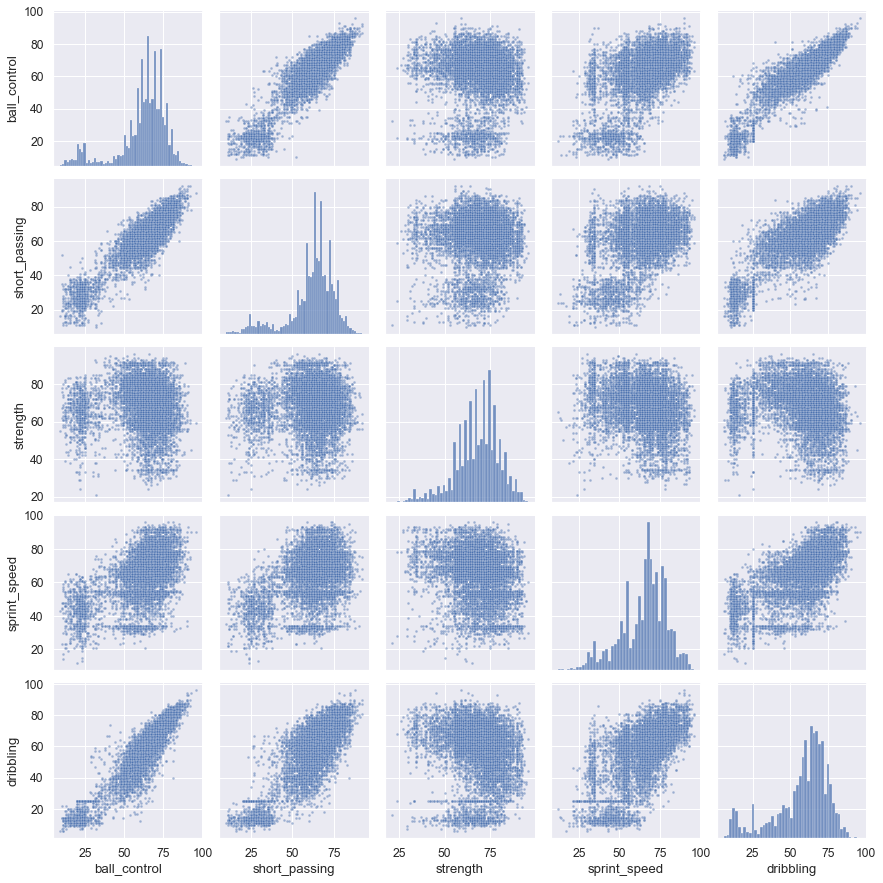

In [825]:
sns.pairplot(DF_TRAIN[cols], plot_kws={'s': 7, 'alpha': 0.5});

**_Experimenting with kind parameters_**

_Kind equals scatter_

* what can you say about these scatterplots? is there anything we can use later?

**_Comment_**
- Some features show relationships close to linear relationships. For example, ball_control and short_passing, ball_control and dribbling, short_passing and dribbling, sprint_speed and dribbling
- Pairs of features that we put to strong (short_passing and ball_control, dribbling and ball_control) look the most close to lines on the pairplot
- Pairs of features that we put to mild (sprint_speed and ball_control, sprint_speed and short_passing) look the mildly close to lines on the pairplot
- other features do not clearly look like lines

**_We can use it to select features that correlate linearly with each other and those detect collinearity and multicollinearity_**

 ### Solve using `sklearn`

In [826]:
model = LinearRegression(fit_intercept=True)
model.fit(x_train, y_train);

* explore fitted model parameters

In [827]:
model_intercept = model.intercept_
model_coef = model.coef_
print(f'model_intercept: {model_intercept}')
print(f'model_coef: {model_coef}')

model_intercept: -4.410760994496634
model_coef: [ 0.98220522 -0.03927767 -0.14440889  0.20772844]


* how to interpret these model parameters?

**_In simple linear regression the formula is y = a*x + b or y = w1*x + w0. Above we see a multivariable regression because if has many parameters (not just 1 intercept and 1 coefficient). In this case model_intercept is a dot where graph intercepts Y-axis (w0) and model_coef is an array of coefficients (array of w1, w2, w3, w4, ..., wn). They are multiplied by x1, x2, x3, x4, ..., xn respectively. W coefficients show us how much each of the features influence the model and in what relationship they are (positive or negative) with the target feature. Consequently, the formula of multivariable regression is y = w0 + w1*x1 + w2*x2 + w3*x3 + ... + wn * xn. Moreover it can be rewritten as y = w0*x0 + w1*x1 + w2*x2 + w3*x3 + ... + wn * xn where x0 equals 1._**

* use fitted model to get predictions for test set

In [828]:
model_preds = model.predict(x_test)
model_preds

array([44.30711902, 61.5246943 , 56.23794497, ..., 64.14903371,
       57.22105591, 75.15698321])

* explore model quality on test set.

In [829]:
print('model metrics on test set')
metrics_test_2 = get_metrics(y_true=y_test, y_pred=model_preds)
metrics_test_2

model metrics on test set


mse     38.192447
mae      4.459334
mape     0.112574
r2       0.887719
dtype: float64

* Let's compare `metrics_test_2` against `metrics_test_1`

In [830]:
# combine 2 series in 1 dataframe
metrics_comparison = metrics_test_1.to_frame('LR_1v').join(metrics_test_2.rename('LR_mv')).T
metrics_comparison

mse       mae      mape        r2
LR_1v  108.345801  8.173553  0.205500  0.681477
LR_mv   38.192447  4.459334  0.112574  0.887719

C:\Users\Anzhe\AppData\Local\Temp/ipykernel_13204/1834340501.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  metrics_comparison.plot(


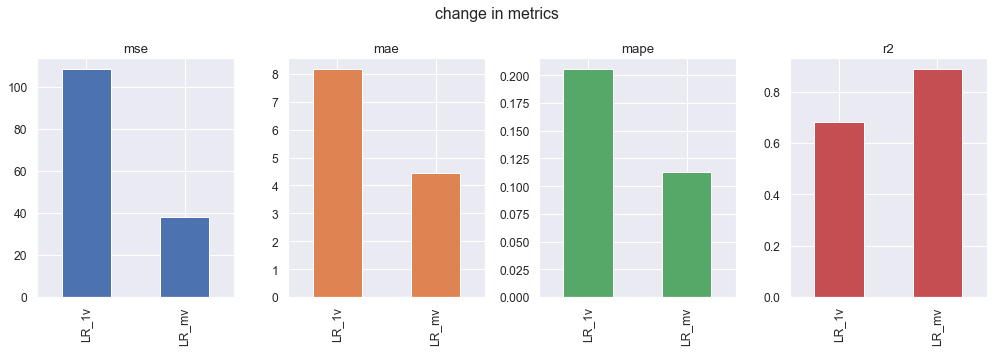

In [831]:
fig, ax = plt.subplots(figsize=(14, 5))  # specify figure size
metrics_comparison.plot(
    kind='bar', layout=(1,4), subplots=True, 
    title='change in metrics', legend=False, ax=ax
);
fig.tight_layout();  # prettify subplots. read more in documentation if interested

* did our Linear regression model improve after we've added more features?

**_The quality has improved when we added more features, compared to the 1 variable model we had before in the model with many features the MSE dropped significantly, MAE and MAPE also decreased a lot, and r2 score increased from 68% to 88%. It is common to compare models by looking at R2, so as I have said R2 has increased in the model with more features, so it has improved._**

### Task 9. Implement Linear regression model with multiple variables yourself (5 points)

Okay, we've fitted Linear regression model using `sklearn` library. Now let's do the math ourselves!

### Prerequisites

For this task you will need to:
* have basic understanding of Linear algebra (operations with vectors and matrices)
* know how to perform matrix multiplication, transposition and inversion using `numpy` 
  (these functions can be found in NumPy documentation)
* carefully read the theory below and refer to wiki / textbooks / other sources if required

---

### Theory and notation

When we extend Linear regression model on case with $m$ variables we get the following formula:

* $ \hat{y}
= 1 \cdot w_0 + x_1 \cdot w_1 + x_2 \cdot w_2 + ... + x_m \cdot w_m
= \sum_{i=0}^{m} x_i w_i
$,

where:
* $x = (1, x_1, ..., x_m)$ is an _(m+1)_-element feature vector. 
    * $x_0 = 1$ is a special term introduced in the beginning of feature vector 
      to add intercept to Linear regression model
    * $x_i, i=\overline{1,m}$ is an _i_-th feature value.
* $w = (w_0, w_1, ..., w_m)$ is an _(m+1)_-element parameter vector
    * $w_0$ - the first value of parameter vector - is referred to as **intercept**
* $\hat{y}$ is a predicted value

----

The formula above is used to calculate predictions for 1 sample.
i.e. we predict 1 scalar $\hat{y}$ from 1 feature vector $x$.

If we have a dataset of $n$ samples $(x, y)$ - we get a system of linear equations:

$
\begin{cases}
 \hat{y}^{(0)} = \sum_{i=0}^{m} x_i^{(0)} w_i \\
 \hat{y}^{(1)} = \sum_{i=0}^{m} x_i^{(1)} w_i \\
 ... \\\
 \hat{y}^{(n-1)} = \sum_{i=0}^{m} x_i^{(n-1)} w_i
\end{cases}
$

Such system can be rewritten in a succinct matrix form (a way that we write equations in Linear algebra):

* $ \hat{y} = X \cdot w $

And the task of minimizing Residual sum of squares (RSS) now looks:
* $ RSS(w, x, y) = \|y - \hat{y}\|_2^2 = \|y - X \cdot w \|_2^2 \rightarrow min $

Here:
* $y = (y^{(0)}, y^{(1)}, ..., y^{(n-1)})$ now denotes a **vector of target values** we want to predict<br>
  $y^{(j)}$ is a target value for _j_-th sample in a dataset.
* $\hat{y} = (\hat{y}^{(0)}, ..., \hat{y}^{(n-1)})$ 
  now denotes a **vector of predictions** <br>
  $\hat{y}^{(j)}$ denotes a predicted value for _j_-th sample in a dataset
* $X$ is a **feature matrix** of shape $n \times (m+1)$. <br>
  _n_ rows correspond to _n_ data samples and _m+1_ columns correspond to _m+1_ features that describe each sample.
* $w = (w_0, w_1, ..., w_m)$ is still a **model parameter vector**
* $X \cdot w$ denotes a **matrix-by-vector** multiplication
* $\|\cdot\|_2$ denotes an $L_2$-norm and is basically a square root of sum of squares of vector elements:<br>
  $\|a\|_2 = \sqrt{a_0^2 + a_1^2 + ... + a_{n-1}^2}$ for an _n_-component vector _a_.
  Thus, RSS means the same as before:<br>
  $ RSS(w, x, y) = \|y - \hat{y}\|_2^2 = 
  (y^{(0)} - \hat{y}^{(0)})^2 + (y^{(1)} - \hat{y}^{(1)})^2 + ... + (y^{(n-1)} - \hat{y}^{(n-1)})^2 = 
  \sum_{j=0}^{n-1} (y^{(j)} - \hat{y}^{(j)})^2
  $

Note:
* we now use **superscripts** $\hat{y}^{(i)}$ instead of **subscripts** $\hat{y}_i$ as before
  to denote _i_-th sample in a dataset
* it is done to be able to refer both to sample index (denoted by superscript)
  and feature index (denoted by subscript) in a single equation. 
  
  Thus:
  * $x^{(j)} = (1, x^{(j)}_1, x^{(j)}_2, ..., x^{(j)}_{m})$  now denotes 
    _j_-th feature vector in a dataset with _m+1_ features
  * $x_i^{(j)}$ denotes an _i_-th feature value of _j_-th feature vector
  * $X = 
  \begin{bmatrix}
      1 & x^{(0)}_1 & x^{(0)}_2 & ... & x^{(0)}_{m} \\
      1 & x^{(1)}_1 & x^{(1)}_2 & ... & x^{(1)}_{m} \\
      ... \\
      1 & x^{(n-1)}_1 & x^{(n-1)}_2 & ... & x^{(n-1)}_{m}
    \end{bmatrix}
    $ is an $n \times (m+1)$ feature matrix. <br><br>
    $X$ can also be written as a column-vector of feature vectors:<br><br>
    $ X = \begin{bmatrix}x^{(0)} \\ x^{(1)} \\ ... \\ x^{(n-1)}\end{bmatrix} $

---

### Fit 

**<TL;DR\>** Enough notation! How can we fit this model?

By minimizin Residual sum of squares (RSS) for a Linear regression equation in a matrix form
we now get a **single** formula to find **all model parameters**!
* $ w = (X^T X)^{-1} X^T y $

Beautiful, isn't it? <br>
Recall, how we got individual formulas for $w_0, w_1$ in case of Linear regression with 1 predictor.<br>
Now we can find the whole parameter vector _w_ at once!

In the formula above:
* $X$ is an $n \times (m+1)$ dimensional feature matrix


* $X^T$ is a **transposed** feature matrix.<br>
  Transposition is a mathematical operation of "swapping" matrix dimensions.<br>
  So $X^T$ is an $(m+1) \times n$ dimensional matrix  


* $ (X^T X)^{-1} $ is the inverse matrix of $ X^T X $

Notes:
* Because of inversion operation performed on $X^T X$ matrix 
  there are difficulties in fitting Linear regression model in some cases.
  
  We will talk more on that later in the assignment.

---
    
If you want to learn more you can refer to 
[Linear least squares](https://en.wikipedia.org/wiki/Linear_least_squares)
wiki-page.

### Implementation

* implement `LRMatrixForm` class and `add_ones_column` function.<br>
  docstrings describe what each function/method should do - so read the docstrings.
  
  
* [what is a docstring?](https://www.python.org/dev/peps/pep-0257/#what-is-a-docstring)


Note:
* `LRMatrixForm` class must support 2 modes: **with** fitting intercept parameter and **without**.<br>
  The behavior is controlled by `fit_intercept` parameter passed to class constructor.

In [832]:
from sklearn.exceptions import NotFittedError

In [833]:
def add_ones_column(x):
    """ 
    Add column consisting of ones to the beginning of matrix `x`. 
    Used when fitting `LRMatrixForm` with `fit_intercept` param set to True.
    """
    # HINTS: 
    # * create a vector that consists of ones: (1, 1, ..., 1)
    # * then use either `np.column_stack` or `np.hstack` function to add this vector to a matrix
    
    # # your code here:
    # return ...
    ones_vector = np.ones(len(x))
    ones_vector_plus_x = np.column_stack((ones_vector, x))
    return ones_vector_plus_x

class LRMatrixForm:
    """
    Class that encapsulates Linear regression model with multiplie variables.
    Calculations are performed using matrix formula.
    
    Use `fit()` method to fit the model on data.
    Use `predict()` method to calculate predictions when the model is fitted.
    """
    def __init__(self, fit_intercept: bool = True):
        """
        fit_intercept: 
        Whether to calculate the intercept for this model. 
        If set to False, no intercept will be used in calculations 
        (i.e. data is expected to be centered).
        """
        self.fit_intercept = fit_intercept
        self.w_ = None  # vector with all model parameters (intercept and weights)
    
    def fit(self, x_train: pd.DataFrame, y_train: pd.Series):
        X = x_train.to_numpy()  # convert pd.DataFrame to numpy matrix
        
        if self.fit_intercept is True:
            # when creating a model with intercept term we need to extend feature matrix
            # with a column consisting of ones (1, 1, ..., 1).
            X = add_ones_column(X)
            
        # # your code here to calculate model parameters:
        Y = np.array(y_train)
        self.w_ = np.linalg.inv(np.transpose(X).dot(X)).dot(np.transpose(X)).dot(Y)
        
    @property
    def coef_(self):
        """ Property that returns model parameters without the intercept term. """
        if self.w_ is None:
            raise NotFittedError()
        # # your code here:
        if self.fit_intercept is True:
            return self.w_[1:]
        else:
            return self.w_
    
    @property
    def intercept_(self):
        """ Property that returns intercept term from model parameters. """
        if self.fit_intercept is not True:
            return 0.0  # for compatibility with sklearn
        if self.w_ is None:
            raise NotFittedError()
        # # your code here:
        return self.w_[0]
    
    def predict(self, x_test: pd.DataFrame):
        """ Generate predictions using fitted model parameters. """
        if self.w_ is None:
            raise NotFittedError()
        
        X = x_test.to_numpy()  # convert pd.DataFrame to numpy matrix
        
        if self.fit_intercept is True:
            X = add_ones_column(X)
            
        # # your code here to calculate predictions
        return X @ self.w_

### Validate your implementation is identical to library version

In [834]:
lr_matrix_form = LRMatrixForm(fit_intercept=True)
fit_and_evaluate(lr_matrix_form, x_train, y_train, x_test, y_test)

mse       mae      mape        r2
train  37.744076  4.423665  0.109928  0.879145
test   38.192447  4.459334  0.112574  0.887719

In [835]:
print(f'intercept: {lr_matrix_form.intercept_}')
print(f'coef: {lr_matrix_form.coef_}')

intercept: -4.410760994495639
coef: [ 0.98220522 -0.03927767 -0.14440889  0.20772844]


In [836]:
assert np.allclose(model.predict(x_test), lr_matrix_form.predict(x_test))
assert round(model.intercept_, 9) == round(lr_matrix_form.intercept_, 9)
assert np.allclose(model.coef_, lr_matrix_form.coef_)

In [837]:
lr_matrix_form.predict(x_test)

array([44.30711902, 61.5246943 , 56.23794497, ..., 64.14903371,
       57.22105591, 75.15698321])

In [838]:
model.predict(x_test)

array([44.30711902, 61.5246943 , 56.23794497, ..., 64.14903371,
       57.22105591, 75.15698321])

* let's take a look at difference between model predictions and target values:

In [839]:
(model.predict(x_test) - y_test).describe()

count    2117.000000
mean       -0.000265
std         6.181464
min       -19.832055
25%        -3.624840
50%        -0.929033
75%         2.657819
max        39.721074
Name: dribbling, dtype: float64

### Now let's compare `sklearn` model and yours with `fit_intercept=False`

In [840]:
model = LinearRegression(fit_intercept=False)
fit_and_evaluate(model, x_train, y_train, x_test, y_test)

mse       mae      mape        r2
train  38.001048  4.462836  0.111262  0.878322
test   38.417697  4.494385  0.114204  0.887057

In [841]:
lr_matrix_form = LRMatrixForm(fit_intercept=False)
fit_and_evaluate(lr_matrix_form, x_train, y_train, x_test, y_test)

mse       mae      mape        r2
train  38.001048  4.462836  0.111262  0.878322
test   38.417697  4.494385  0.114204  0.887057

* Compare the metrics on a test set of a model fitted **with** intercept parameter 
  vs model fitted **without** intercept.
* Which model has a better performance? Can you explain why?

**_A model WITHOUT intercept has slightly bigger MSE, MAE, MAPE than a model with intercept. Also, a model WITHOUT intercept has slightly lower R2 than a model with intercept. Consequently, the model with intercept has a slightly better perfomance._**

**_I can explain it like this. When we remove an intercept we constrain our model because it kind of stucks at the Y = 0 (intercept is an intersection with Y-axis), so it cannot fit exactly in the data and becomes worse than a model with intercept_**

In [842]:
print(f'intercept: {lr_matrix_form.intercept_}')
print(f'coef: {lr_matrix_form.coef_}')

intercept: 0.0
coef: [ 0.99382995 -0.05758452 -0.17865978  0.18315944]


In [843]:
assert np.allclose(model.predict(x_test), lr_matrix_form.predict(x_test))
assert round(model.intercept_, 9) == round(lr_matrix_form.intercept_, 9)
assert np.allclose(model.coef_, lr_matrix_form.coef_)

* let's take a look at difference between model predictions and target values again:

In [844]:
(model.predict(x_test) - y_test).describe()

count    2117.000000
mean        0.069583
std         6.199275
min       -20.437460
25%        -3.706841
50%        -0.888994
75%         2.766454
max        39.316868
Name: dribbling, dtype: float64

* compare this to the same statistics obtained with model fitted **with intercept**
* notice how the _mean_ value of difference changed

**_As we can see without the intercept mean increased, std increased, min decreased, 25% decreased, 50% increased, 75% increased and max decreased. However, all of those are slight changes._**

**_To underline, mean value became more far away from 0 in the model without the intercept. Linear regression tries to optimize the sum of the distances between corresponding predicted and actual points on the graph, so mean tends to become close to 0. When we constrain our model by getting of the intercept, it constrains model's mean opportunities to become close to 0, so mean is more far away from 0 than in the model with intercept_**

## Limitations of Linear regression

Recall the formula to find Linear regression parameters in case of multiple variables:
* $ w = (X^T X)^{-1} X^T y $

As noted above, there might be difficulties with fitting Linear regression model
because of inverting $X^T X$ matrix.

Not every matrix can be inverted.

An example of such case is when 2 or more features have strong linear relationship between them.<br>
It means that one of variables can be **linearly predicted from the others with a substantial degree of accuracy**.<br>
Such situation is named **collinearitry** (in case of 2 related variables)
or **multicollinearity** (>2 related features).<br>

Collinearity is associated with high value of correlation coefficient between 2 related features.

You can refer to [multicollinearity](https://en.wikipedia.org/wiki/Multicollinearity) 
wiki page to read more.

The intuition why multicollinearity is bad is that Linear Regression tries to capture 
a contribution of each individual feature to target independently of other features.
This is not possible with the data that has collinear features, 
as change in one such variable is always associated with change in other/others.

There are a whole bunch of really interesting thoughts that can help you 
to capture the intuition behind the concept of multicollinearity.<br>
You can find some of them 
[here](https://stats.stackexchange.com/questions/1149/is-there-an-intuitive-explanation-why-multicollinearity-is-a-problem-in-linear-r).

### Collinearity

* Let's construct and add a new feature to our dataset that is going to be _collinear_ with another one:

In [845]:
# select features as usual
target = 'dribbling'
features = ['ball_control', 'short_passing', 'strength', 'sprint_speed']
x_train, y_train, x_test, y_test = get_train_test_data(features, target)

In [846]:
def add_collinear_column(_df: pd.DataFrame, orig_col: str, new_col: str):    
    """ 
    Construct new column as a linear transform of another one + tiny noise.
    y = f(x) = a1 * x + a2 + noise.
    
    Alternatively, we could apply no linear transform at all (set a1=1, a2=0)
    And only add some noise to existing column. Results would be the same.
    """
    # linear transform
    _df[new_col] = 2 * _df[orig_col] + 3
    # add tiny normal noise
    _df[new_col] += np.random.normal(loc=0, scale=0.0001, size=_df.shape[0])

orig_col = 'sprint_speed'
new_col = 'sprint_speed_2'
add_collinear_column(x_train, orig_col, new_col)
add_collinear_column(x_test, orig_col, new_col)
features.append(new_col)

In [847]:
corr_coef = np.corrcoef(x_train[orig_col], x_train[new_col])[0, 1]
print(f'correlation between {orig_col} and {new_col}: {corr_coef}')

correlation between sprint_speed and sprint_speed_2: 0.9999999999935796


* As expected, correlation coefficient between collinear features 
  (`sprint_speed` and `sprint_speed_2`) is close to 1.<br>
  Thus they are highly correlated.

In [848]:
# visualize sample of train data
check = x_train.sample(5).copy()
# add helper column to see how much noise was added
check['sprint_speed_2_wo_noise'] = 2 * check['sprint_speed'] + 3
check

ball_control  short_passing  strength  sprint_speed  sprint_speed_2  \
50497           73.0           68.0      70.0          85.0      173.000024   
106182          57.0           63.0      67.0          61.0      124.999960   
77957           68.0           63.0      87.0          53.0      108.999996   
128800          73.0           60.0      75.0          82.0      166.999881   
40723           20.0           30.0      81.0          42.0       87.000111   

        sprint_speed_2_wo_noise  
50497                     173.0  
106182                    125.0  
77957                     109.0  
128800                    167.0  
40723                      87.0

### let's fit a Linear Regression model on this feature set:

In [849]:
model = LinearRegression(fit_intercept=True)
fit_and_evaluate(model, x_train, y_train, x_test, y_test)

mse       mae      mape        r2
train  37.742193  4.423590  0.109931  0.879151
test   38.203981  4.459602  0.112574  0.887685

* Both train and test metrics look reasonable
* Now let's explore model params:

In [850]:
print(f'intercept: {model.intercept_}')
print(f'coef: {model.coef_.tolist()}')

intercept: 1300.4348314571382
coef: [0.9822931754258959, -0.03933372136534011, -0.14439366551378238, 870.1057471275288, -434.9490173531945]


* Weights that correspond to `sprint_speed` and `sprint_speed_2` columns should have gone insanely high!


* That is not ok. Large weights and weights instability are the sign of 
    [**overfitting**](https://en.wikipedia.org/wiki/Overfitting).

    According to the definition, overfitting is:<br>
    "_the production of an analysis that corresponds too closely 
    or exactly to a particular set of data,<br>
    and may therefore fail to fit additional data 
    or predict future observations reliably_".
    
    
* But what does that mean? Let's try to generate predictions with our model.

### generate predictions using our fitted model

In [851]:
check = x_test.head(2).copy()
check[target] = y_test.head(2)
check['preds'] = model.predict(check[features])
check

ball_control  short_passing  strength  sprint_speed  sprint_speed_2  \
147541          51.0           60.0      68.0          52.0      107.000032   
147549          65.0           69.0      66.0          69.0      141.000022   

        dribbling      preds  
147541       49.0  44.292863  
147549       59.0  61.515226

In [852]:
get_metrics(y_true=check[target], y_pred=check['preds'])

mse     14.241748
mae      3.611181
mape     0.069347
r2       0.430330
dtype: float64

* predictions look good, right? 

**_I would not say that predictions look good since R2 is just 43% but MSE, MAE and MAPE look good_**

### but what if we change `sprint_speed` values a bit? let's add some small `delta`

In [853]:
delta = 1  # some small value
check['sprint_speed'] += delta
check['preds_2'] = model.predict(check[features])
check

ball_control  short_passing  strength  sprint_speed  sprint_speed_2  \
147541          51.0           60.0      68.0          53.0      107.000032   
147549          65.0           69.0      66.0          70.0      141.000022   

        dribbling      preds     preds_2  
147541       49.0  44.292863  914.398611  
147549       59.0  61.515226  931.620973

In [854]:
get_metrics(y_true=check[target], y_pred=check['preds_2'])

mse     755191.058562
mae        869.009792
mape        16.225691
r2      -30206.642342
dtype: float64

* Wow, new predictions doesn't look even close to the target!<br>
  Our model doesn't look like a good model anymore.
  

* That is exactly what overfitting is. <br>
  **We fail to obtain reasonable predictions when we apply our model on new data**.

### One might notice that we have changed only 1 of 2 collinear features
* Indeed, giant model weights that correspond to these 2 features, should cancel each one out<br>
  if relation between feature values stays the same.  

* Let's check this out.<br>
  We have performed following transform:<br>
  `sprint_speed_changed = sprint_speed + delta`<br>
  

* How should we change `sprint_speed_2` to match the same data distribution from train data?<br>
  
  Let's calculate (we will ignore the noise added):  
  `sprint_speed_2_changed - sprint_speed_2 = f(sprint_speed_changed) - f(sprint_speed) =`<br>
  `= a1 * sprint_speed_changed + a2 - (a1 * sprint_speed + a2) = a1 * delta`

In [855]:
# here we change the second of collinear features 
# using the same coefficient 
# that was used in linear transform in `add_collinear_column()` function.
# we don't need to add intercept coefficient as it cancels it out (you can do the math yourself).
check['sprint_speed_2'] += 2 * delta
check['preds_3'] = model.predict(check[features])
check

ball_control  short_passing  strength  sprint_speed  sprint_speed_2  \
147541          51.0           60.0      68.0          53.0      109.000032   
147549          65.0           69.0      66.0          70.0      143.000022   

        dribbling      preds     preds_2    preds_3  
147541       49.0  44.292863  914.398611  44.500576  
147549       59.0  61.515226  931.620973  61.722938

* In the last example we see that new predictions (`preds_3`) now look similar to the first ones <br>
  (`preds` - calculated before changing `sprint_speed` value)


* So, if values of collinear features change accordingly - we are safe, right? <br>
  How do your think, can we always rely on this assumtion?

**_In this particular case it worked but we cannot be sure that it will always work since we tried it in only one example. So NO we cannot always rely on this assumption._**

### What just happened

* The answer to the question above is: **no, we can't**.
  
  
* Yes, we have checked that if collinear features values are changed accordingly 
  (i.e. their **initial relation is preserved**), <br>
  model predictions look reasonable and accurate.
  
  But this will not always be the case on the real data.
  
  We can't be sure that the data 
  that we apply our fitted model on (`x_test`, for example)<br>
  preserves **exactly the same data distribution** as the data that model was trained on (`x_train`).
  
  

**Why this happened?**

* When feature matrix contains collinear or multicollinear features (the problem of **multicollinearity**),
  inversion of such a matrix is numerically unstable.<br>
  This leads to large values and imprecise estimates of model parameters.

**How to detect multicollinearity**
* You should monitor your model weights. For example using $L_2$ norm:<br>
  $ L_2(w) = \|w\|_2 = \sqrt{w_1^2 + w_2^2 + ... + w_n^2} = \sqrt{\sum_{i=1}^{n} w_i^2} $<br>
  If any of model weights are huge - $L_2$ norm will also have large value.
  
  
* Monitor model performance on validation data. 
  If the metrics are poor and prediction look huge,<br>
  you should check if collinear features are present in train data.

**How to fix the issue**

* For each set of collinear features, keep only 1 of them and remove the rest.<br>
  The best regression models are those in which the predictor variables each correlate highly 
  with the target variable,<br>
  but correlate at most only minimally with each other.
  

* Combine collinear features into new ones

  
* Use regularization (will be covered later in the course).

### Task 10. Implement function to calculate $L_2$-norm. (1 point)
* Use formula above to implement $L_2$ norm

In [856]:
def l2_norm(arr: Iterable):
    return np.sqrt(np.sum(np.square(arr)))

### Calculate $L_2$-norm value for current model
* you should get high value that represents large values of some model parameters

In [857]:
l2_norm(model.coef_)

972.7618650920787

**_Yes, the valus is high_**

### Multicollinearity
  
* It's important to notice that in case of multicollinearity,
  correlation coefficient between each pair of related variables
  could be **not so high**.
  
  So **it may be hard to find multicollinear features in your data**.
  

* Let's visualize it in practice.

  We will build a new feature that has a strong linear relationship with 2 other features:
  $x_1 = a_0 + a_2 x_2 + a_3 x_3 + noise$

  We want to show that Linear regression model will still suffer from multicollinearity,<br>
  but correlation coefficients betweent each pair of multicollinear features will be **less close to 1**
  than it was in case of collinearity.

In [858]:
target = 'dribbling'
features = ['ball_control', 'short_passing', 'strength', 'sprint_speed']
x_train, y_train, x_test, y_test = get_train_test_data(features, target)

def add_collinear_column(_df: pd.DataFrame, col1: str, col2: str, new_col: str):    
    _df[new_col] = _df[col1] + _df[col2] + 5
    _df[new_col] += np.random.normal(loc=0, scale=0.0001, size=_df.shape[0])

add_collinear_column(x_train, col1='sprint_speed', col2='strength', new_col='foo')
add_collinear_column(x_test, col1='sprint_speed', col2='strength', new_col='foo')
features.append(new_col)

model = LinearRegression(fit_intercept=True)
m = fit_and_evaluate(model, x_train, y_train, x_test, y_test)
display(m)
print(f'intercept: {model.intercept_}')
print(f'coef: {model.coef_.tolist()}')

mse       mae      mape        r2
train  37.743612  4.423490  0.109927  0.879147
test   38.194010  4.459613  0.112595  0.887714

intercept: 1065.0034085924583
coef: [0.9821914080723756, -0.039282583054995775, 213.73849275408554, 214.09059825100715, -213.8828764710043]


* As before, model parameters for multicollinear features should be large

* Let's calculate $L_2$-norm value - it should also be large

In [859]:
l2_norm(model.coef_)

370.49396571989774

#### Task 11. Visualize correlation matrix for `x_train`  (1 point)
* Build annotated heatmap (use `annot` param to add values to plot, select diverging `cmap` and center it at 0)
* You should see that `foo` feature is correlated with ones it was created from,<br>
  but each of these correlation coefficients **is not so close to 1**

<AxesSubplot:>

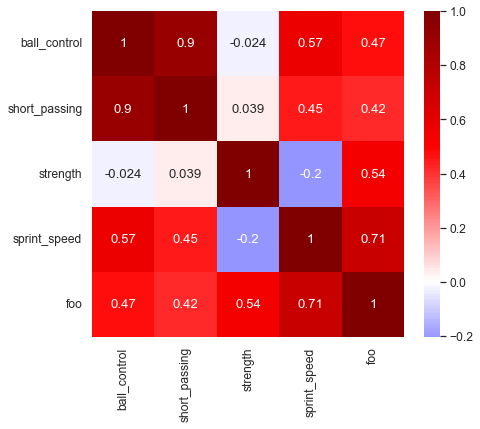

In [860]:
correlation_matrix_2 = x_train.corr()
sns.heatmap(data=correlation_matrix_2, annot=True, cmap='seismic', center=0)

### Regularization

* The concept of regularization (that was mentioned above) is simple.

  We modify Loss function (RSS in case of Linear regression) in such a way<br>
  to penalize for large values of model parameters.
  
  
* $L_2$ regularization, also named as 
  [Tikhonov regularization](https://en.wikipedia.org/wiki/Tikhonov_regularization), 
  adds $L_2$ term to loss function:

  $L(w,x,y) = RSS(w,y) + \alpha L_2(w) = \|y - \hat{y}\|_2^2 + \alpha \|w\|_2^2 
  = \|y - X \cdot w \|_2^2 + \alpha \|w\|_2^2$
  
  parameter $ \alpha \ge 0 $ controls the ammount of regularization applied
  

* Linear regression implemented with $L_2$ regularization is named a **Ridge regression**.


* Ridge regression is implemented in `Ridge` class in `sklearn` library

---

Let's see how applying regularization changes our model.

In [861]:
from sklearn.linear_model import Ridge

* at first fit `Ridge` without any regularization to ensure we get similar results 
  to using `LinearRegression`

In [862]:
# `solver` parameters determines the algorithm used to solve regression task.
# we fix it to be `svd` to achieve desired results.
model_r = Ridge(alpha=0, fit_intercept=True, solver='svd')
fit_and_evaluate(model_r, x_train, y_train, x_test, y_test)

mse       mae      mape        r2
train  37.743612  4.423490  0.109927  0.879147
test   38.194010  4.459613  0.112595  0.887714

In [863]:
print(f'intercept: {model_r.intercept_}')
print(f'coef: {model_r.coef_.tolist()}')
print(f'l2 norm: {l2_norm(model_r.coef_)}')

intercept: 1065.0034085924692
coef: [0.9821914080723771, -0.03928258305501642, 213.73849275408745, 214.0905982510091, -213.88287647100623]
l2 norm: 370.49396571990104


* some model parameters should be large, as well as the $L_2$-norm value
* now, let's add some regularization

In [864]:
model_r = Ridge(alpha=0.01, fit_intercept=True, solver='svd')
fit_and_evaluate(model_r, x_train, y_train, x_test, y_test)

mse       mae      mape        r2
train  37.744073  4.423664  0.109928  0.879145
test   38.192450  4.459334  0.112574  0.887719

In [865]:
print(f'intercept: {model_r.intercept_}')
print(f'coef: {model_r.coef_.tolist()}')
print(f'l2 norm: {l2_norm(model_r.coef_)}')

intercept: -1.4665650561080668
coef: [0.9822051553997277, -0.03927765429271218, 0.4444303826453675, 0.7965676292666258, -0.5888392129528532]
l2 norm: 1.4645953957135183


* notice how parameter values changed
* also notice how $L_2$-norm values decreased

**_I notice that parameters are not so big, and l2-norm really decreased_**

## Task 12. Putting all together. (up to 10 points)

In the final task we'll try to recap all that we have learnt so far.

Your task is to build a Linear regression model with multiple variables to predict `agility` variable.<br>
Only `LinearRegression` class is allowed to be used for modeling.<br>

Steps you need to follow:

* Make a new train/test split with new proportion: 70% on train and 30% on test data **(1 point)**


* Fit a model **(up to 6 points)**
    
    * Choose >= 10 features from training set as initial set of features
      Explain your choice. **(1 point)**
      
    * Visualize correlation matrix for selected features **(1 point)**
    
    * Analyze if collinear/multicollinear features are present in your feature set.<br>
      Process collinear/multicollinear features if they are present:<br>
      remove redundant features, combine features into new ones, etc **(up to 3 points)**
     
    * Fit the model and calculate metrics on train and test sets<br>
      **(1 point max. -0.25 points per each metric that was not implemented in the beginning of the assignment)**
    

* Analyze fitted model performance **(up to 2 points)**:
    * Print fitted model parameters and calculate their $L_2$-norm value **(1 point)**
    * Make conclusion whether your model overfitted or not. Provide your arguments. **(1 point)**


* Write a short report about the work done **(1 point)**<br>
  Can you find a logical explanation for high correlation of some of your features?<br>
  Are you satisfied with the quality of predictions?<br>
  How could you pottentially improve the model?<br>
  Any other thoughts.


**Penalties:**
- **0 points are assigned for the whole task** if used a model different from:
    - `sklearn.linear_model.LinearRegression`
    - or `LRMatrixForm`

### Let's make a train/test split with a proportion of 70% train and 30% test data

In [866]:
print(df.shape)
ix_split = int(0.7 * df.shape[0])
DF_TRAIN = df.iloc[:ix_split].copy()
DF_TEST = df.iloc[ix_split:].copy()
print(DF_TRAIN.shape, DF_TEST.shape)

(10582, 35)
(7407, 35) (3175, 35)


In [867]:
print(f"{DF_TRAIN.shape[0]/df.shape[0]*100}% {DF_TEST.shape[0]/df.shape[0]*100}%")

69.99621999622% 30.003780003780005%


As we can see from the sell above the proportion is right.

### Fit a model

#### Choose 10+ features

I see 2 ways of choosing initial features:

1. Analyze what features mean and try to logically understand what characteristics of players can assosiate with agility. For example, we have features like "Aggression" which might influence agility because aggression can be assotiated with fast reaction. However, this approach depends a lot on my inner knowledge and to have better results it would be better to consult football coaches or playes. We unfortunatelly don't have this opportunity in a study task. I myself can include some useless features, for instance, "Sliding tackle" when it is not needed or on a contrary do not include some feature like "Aggression" when it is needed".

2. Visualize a correlation matrix of features and take 15 of the most correlated features with agility. This approach gets rid of my guesses of whether features like "Vision" or "Jumping" influence agilty.

Let's take the way #2. So as I said we will draw a correlation of all features in our dataset and from it decide on initial 10+ (in my case let's try 15) features to select, so we don't have personal biases or use poor knowledge of football. Moreover, we will analyze features that corr showed.

In [868]:
correlation_matrix = df.corr()
correlation_matrix

overall_rating  potential  crossing  finishing  \
overall_rating            1.000000   0.815249  0.293684   0.266877   
potential                 0.815249   1.000000  0.242029   0.244247   
crossing                  0.293684   0.242029  1.000000   0.602687   
finishing                 0.266877   0.244247  0.602687   1.000000   
heading_accuracy          0.236246   0.165555  0.402634   0.394889   
short_passing             0.412008   0.367661  0.803246   0.609391   
volleys                   0.304024   0.248509  0.654547   0.870419   
dribbling                 0.296112   0.317433  0.829761   0.789398   
curve                     0.326502   0.268560  0.817277   0.711735   
free_kick_accuracy        0.283547   0.204085  0.732209   0.657718   
long_passing              0.392166   0.320514  0.744029   0.421171   
ball_control              0.380553   0.365276  0.827153   0.738709   
acceleration              0.174668   0.299818  0.576943   0.501686   
sprint_speed              0.188511   0.309311  0.556556   0.481219   
agility                   0.215998   0.267011  0.618485   0.553901   
reactions                 0.787206   0.602781  0.311563   0.291960   
balance                   0.100119   0.161929  0.577861   0.423846   
shot_power                0.347885   0.274228  0.683626   0.749742   
jumping                   0.233605   0.172163  0.048116   0.014281   
stamina                   0.241977   0.233792  0.584142   0.376077   
strength                  0.215589   0.065608 -0.136503  -0.085452   
long_shots                0.326083   0.265409  0.729019   0.826329   
aggression                0.269096   0.146234  0.377988   0.106609   
interceptions             0.203424   0.121259  0.329211  -0.175514   
positioning               0.285609   0.256299  0.727912   0.870469   
vision                    0.409411   0.349201  0.691808   0.677950   
penalties                 0.278143   0.215750  0.620951   0.795875   
marking                   0.122011   0.068372  0.274110  -0.248159   
standing_tackle           0.152052   0.097823  0.324442  -0.186195   
sliding_tackle            0.134891   0.089100  0.312264  -0.224519   
gk_diving                 0.029723  -0.008990 -0.654603  -0.519915   
gk_handling               0.032112  -0.008277 -0.651642  -0.513952   
gk_kicking                0.028797  -0.011134 -0.647341  -0.516438   
gk_positioning            0.032090  -0.011421 -0.654693  -0.519262   
gk_reflexes               0.032358  -0.007122 -0.656178  -0.520261   

                    heading_accuracy  short_passing   volleys  dribbling  \
overall_rating              0.236246       0.412008  0.304024   0.296112   
potential                   0.165555       0.367661  0.248509   0.317433   
crossing                    0.402634       0.803246  0.654547   0.829761   
finishing                   0.394889       0.609391  0.870419   0.789398   
heading_accuracy            1.000000       0.579282  0.406924   0.448041   
short_passing               0.579282       1.000000  0.652236   0.812938   
volleys                     0.406924       0.652236  1.000000   0.784317   
dribbling                   0.448041       0.812938  0.784317   1.000000   
curve                       0.356718       0.755942  0.760770   0.822143   
free_kick_accuracy          0.338306       0.715015  0.708657   0.723443   
long_passing                0.456997       0.880310  0.495958   0.666167   
ball_control                0.589430       0.905642  0.755249   0.920367   
acceleration                0.156921       0.465631  0.470034   0.685186   
sprint_speed                0.225398       0.452852  0.448022   0.655831   
agility                     0.089995       0.521943  0.547171   0.713123   
reactions                   0.203711       0.394963  0.335563   0.301088   
balance                     0.057231       0.490882  0.442740   0.606836   
shot_power                  0.581341       0.746555  0.768610   0.763753   
jumping                     0.247838       0.075297  0.

This matrix is too big, so it's not helpful. Moreover, it contains correlations with other features (not only with agility). Let's leave only correlations with agility and sort them, so we can see which features had the highest correlation with agility.

In [869]:
correlation_matrix_with_agility = correlation_matrix[['agility']]
corr_matrix_with_agility_sorted = correlation_matrix_with_agility.sort_values(by=['agility'], ascending=False)
corr_matrix_with_agility_sorted = corr_matrix_with_agility_sorted.drop('agility')
corr_matrix_with_agility_sorted

agility
acceleration        0.797346
balance             0.742262
sprint_speed        0.730343
dribbling           0.713123
ball_control        0.625814
positioning         0.620826
crossing            0.618485
curve               0.611963
long_shots          0.555267
finishing           0.553901
vision              0.550416
volleys             0.547171
short_passing       0.521943
free_kick_accuracy  0.503993
stamina             0.482563
shot_power          0.463734
penalties           0.459486
long_passing        0.426705
potential           0.267011
reactions           0.252051
overall_rating      0.215998
jumping             0.185940
heading_accuracy    0.089995
aggression          0.055090
interceptions      -0.029564
sliding_tackle     -0.043100
standing_tackle    -0.048907
marking            -0.085376
gk_kicking         -0.397502
gk_handling        -0.398713
gk_positioning     -0.402400
gk_diving          -0.402478
gk_reflexes        -0.402946
strength           -0.408930

Now let's analyze them. As we can see there is no really strong correlation of higher than 0.8 or lower -0.8 with agility. Let's examine 15 features with highest correlation (moderate and high) from logical point of view (they have correlation higher than 0.48 or lower than -0.48) using this dictionary of football players skills https://www.fifplay.com/encyclopedia/:

**Agility** - ability of a sportsman to rotate fast or stop fast with a ball, perform kicks that require acrobatics (like jumping in the air), it influences the quality of  feint, a player deceiving the opposition into believing he is going to pass, shoot, move in a certain direction, or receive the ball and instead doing something entirely different, thus gaining an advantage.

**Acceleration** - how fast a person can gain velocity **Can logically correlate with Agility because Agility is about rotating and stopping fast**

**balance** - probability to stand on legs after a physical contact, collisions and while opponent is trying to take their ball. **Can logically correlate with Agility because to stop fast (agility) you need to have a balance**

**sprint_speed** - max speed of a person. According to the research https://rua.ua.es/dspace/bitstream/10045/39576/1/jhse_Vol_9_N_I_49-58.pdf about the relationship of speed factors and agility in sport games, speed is a part of an agility. Exhibition of both speed and agility in team
sports occurs in response to game situations. It follows that perception-action coupling and decisionmaking are critical elements in terms of developing the ability to express speed and agility capabilities
under match conditions. **Can logically correlate with Agility because of the reasons mentioned before**

**dribbling** - maneuvering a ball by one player while moving in a given direction, avoiding defenders' attempts to intercept the ball **Can logically correlate with Agility because its a part of an agility to be able to do actiongs with a ball**

**ball_control** - an offensive strategy (as in football) in which a team tries to keep possession of the ball for extended periods of time. **Can logically correkate with Agility because the more you can control the ball the more agile you are**

**positioning** - ability to get a better position while attacking **I don't know how it can correlate with Agility, maybe putting yourself in a better posioning is about ability to think quickly and those act quickly as agility requires. We will keep it for now because of correlation matrix**

**crossing** - the intention of a cross is to directly bring the ball into the box from an angle that allows the attacking forwards to more easily aim for goal with their head or feet **I don't know how it can correlate with Agility but we will it keep because of correlation_matrix results**

**curve** - ability to spin the ball which makes the ball move in a curved direction **Might logically correlate with Agility if spinning the ball relates to kicks that require acrobatics**

**long_shots** - hit a long hard pass to the player, who has one-touch, then must shoot from long range **I don't know how it can correlate with Agility but we will it keep because of correlation_matrix results**

**finishing** - a skill that determines the accuracy of any player's shot on goal from the field and the ability to outplay the goalkeeper and defenders who are trying to block the shot **Can logically correlaate with agility because its about ourplaying defenders with fints**

**vision** - the ability to see potential passes **Might have an association with agility because both of them require fast reaction**

**volleys** - an air-borne strike in association football, where a player's foot meets and directs the ball in an angled direction before it has time to reach the ground **Can logically correlates with agility because volleys are related to quicks that require acrobatics**

**short_passing** - a skill that determines the accuracy and power of passing the ball to the football player of his team on the bottom **I don't know how it can correlate with Agility but we will it keep because of correlation_matrix results**

**free_kick_accuracy** - the higher the value of this indicator, the better the accuracy of hitting, passing or passing at standard positions; **I don't know how it can correlate with Agility but we will it keep because of correlation_matrix results**

**stamina** - the higher this indicator, the slower the player gets tired during the match **I don't know how it can correlate with Agility but we will it keep because of correlation_matrix results**

I underline that I have no football knowledge and my thoughts are just assumptions. To conclude, we will keep these 15 features because correlation matrix showed that they had the highest correlation with agility among other features.

Now, let's leave 15 features with the highest correlation with agility (15 because all of them would be too much)

In [870]:
corr_matrix_with_agility_sorted = corr_matrix_with_agility_sorted.head(15)

In [871]:
print(f"Now we have correlations of all features with agility target featute. In total we selected {corr_matrix_with_agility_sorted.shape[0]} initial features. We will reduce their amount in following steps.")

Now we have correlations of all features with agility target featute. In total we selected 15 initial features. We will reduce their amount in following steps.


#### Visualize correlation matrix for features

Let's visualize correlation matrix for selected features with agility.

<AxesSubplot:>

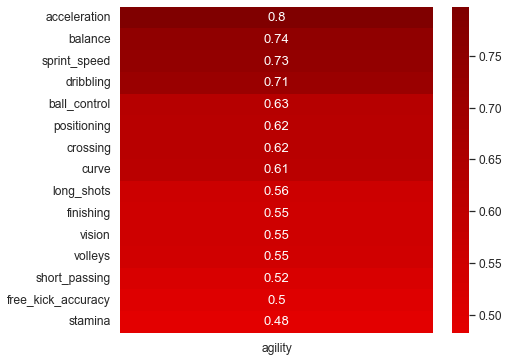

In [872]:
sns.heatmap(corr_matrix_with_agility_sorted, center=0, cmap='seismic', annot=True)

Above we see 15 features with a highest correlation with "agility" target feature. Let's take them as selected features.

In [873]:
target = 'agility'
features = list(corr_matrix_with_agility_sorted.index)
# let's select initial x_train
x_train, y_train, x_test, y_test = get_train_test_data(features, target)
cols = features + [target]
cols

['acceleration',
 'balance',
 'sprint_speed',
 'dribbling',
 'ball_control',
 'positioning',
 'crossing',
 'curve',
 'long_shots',
 'finishing',
 'vision',
 'volleys',
 'short_passing',
 'free_kick_accuracy',
 'stamina',
 'agility']

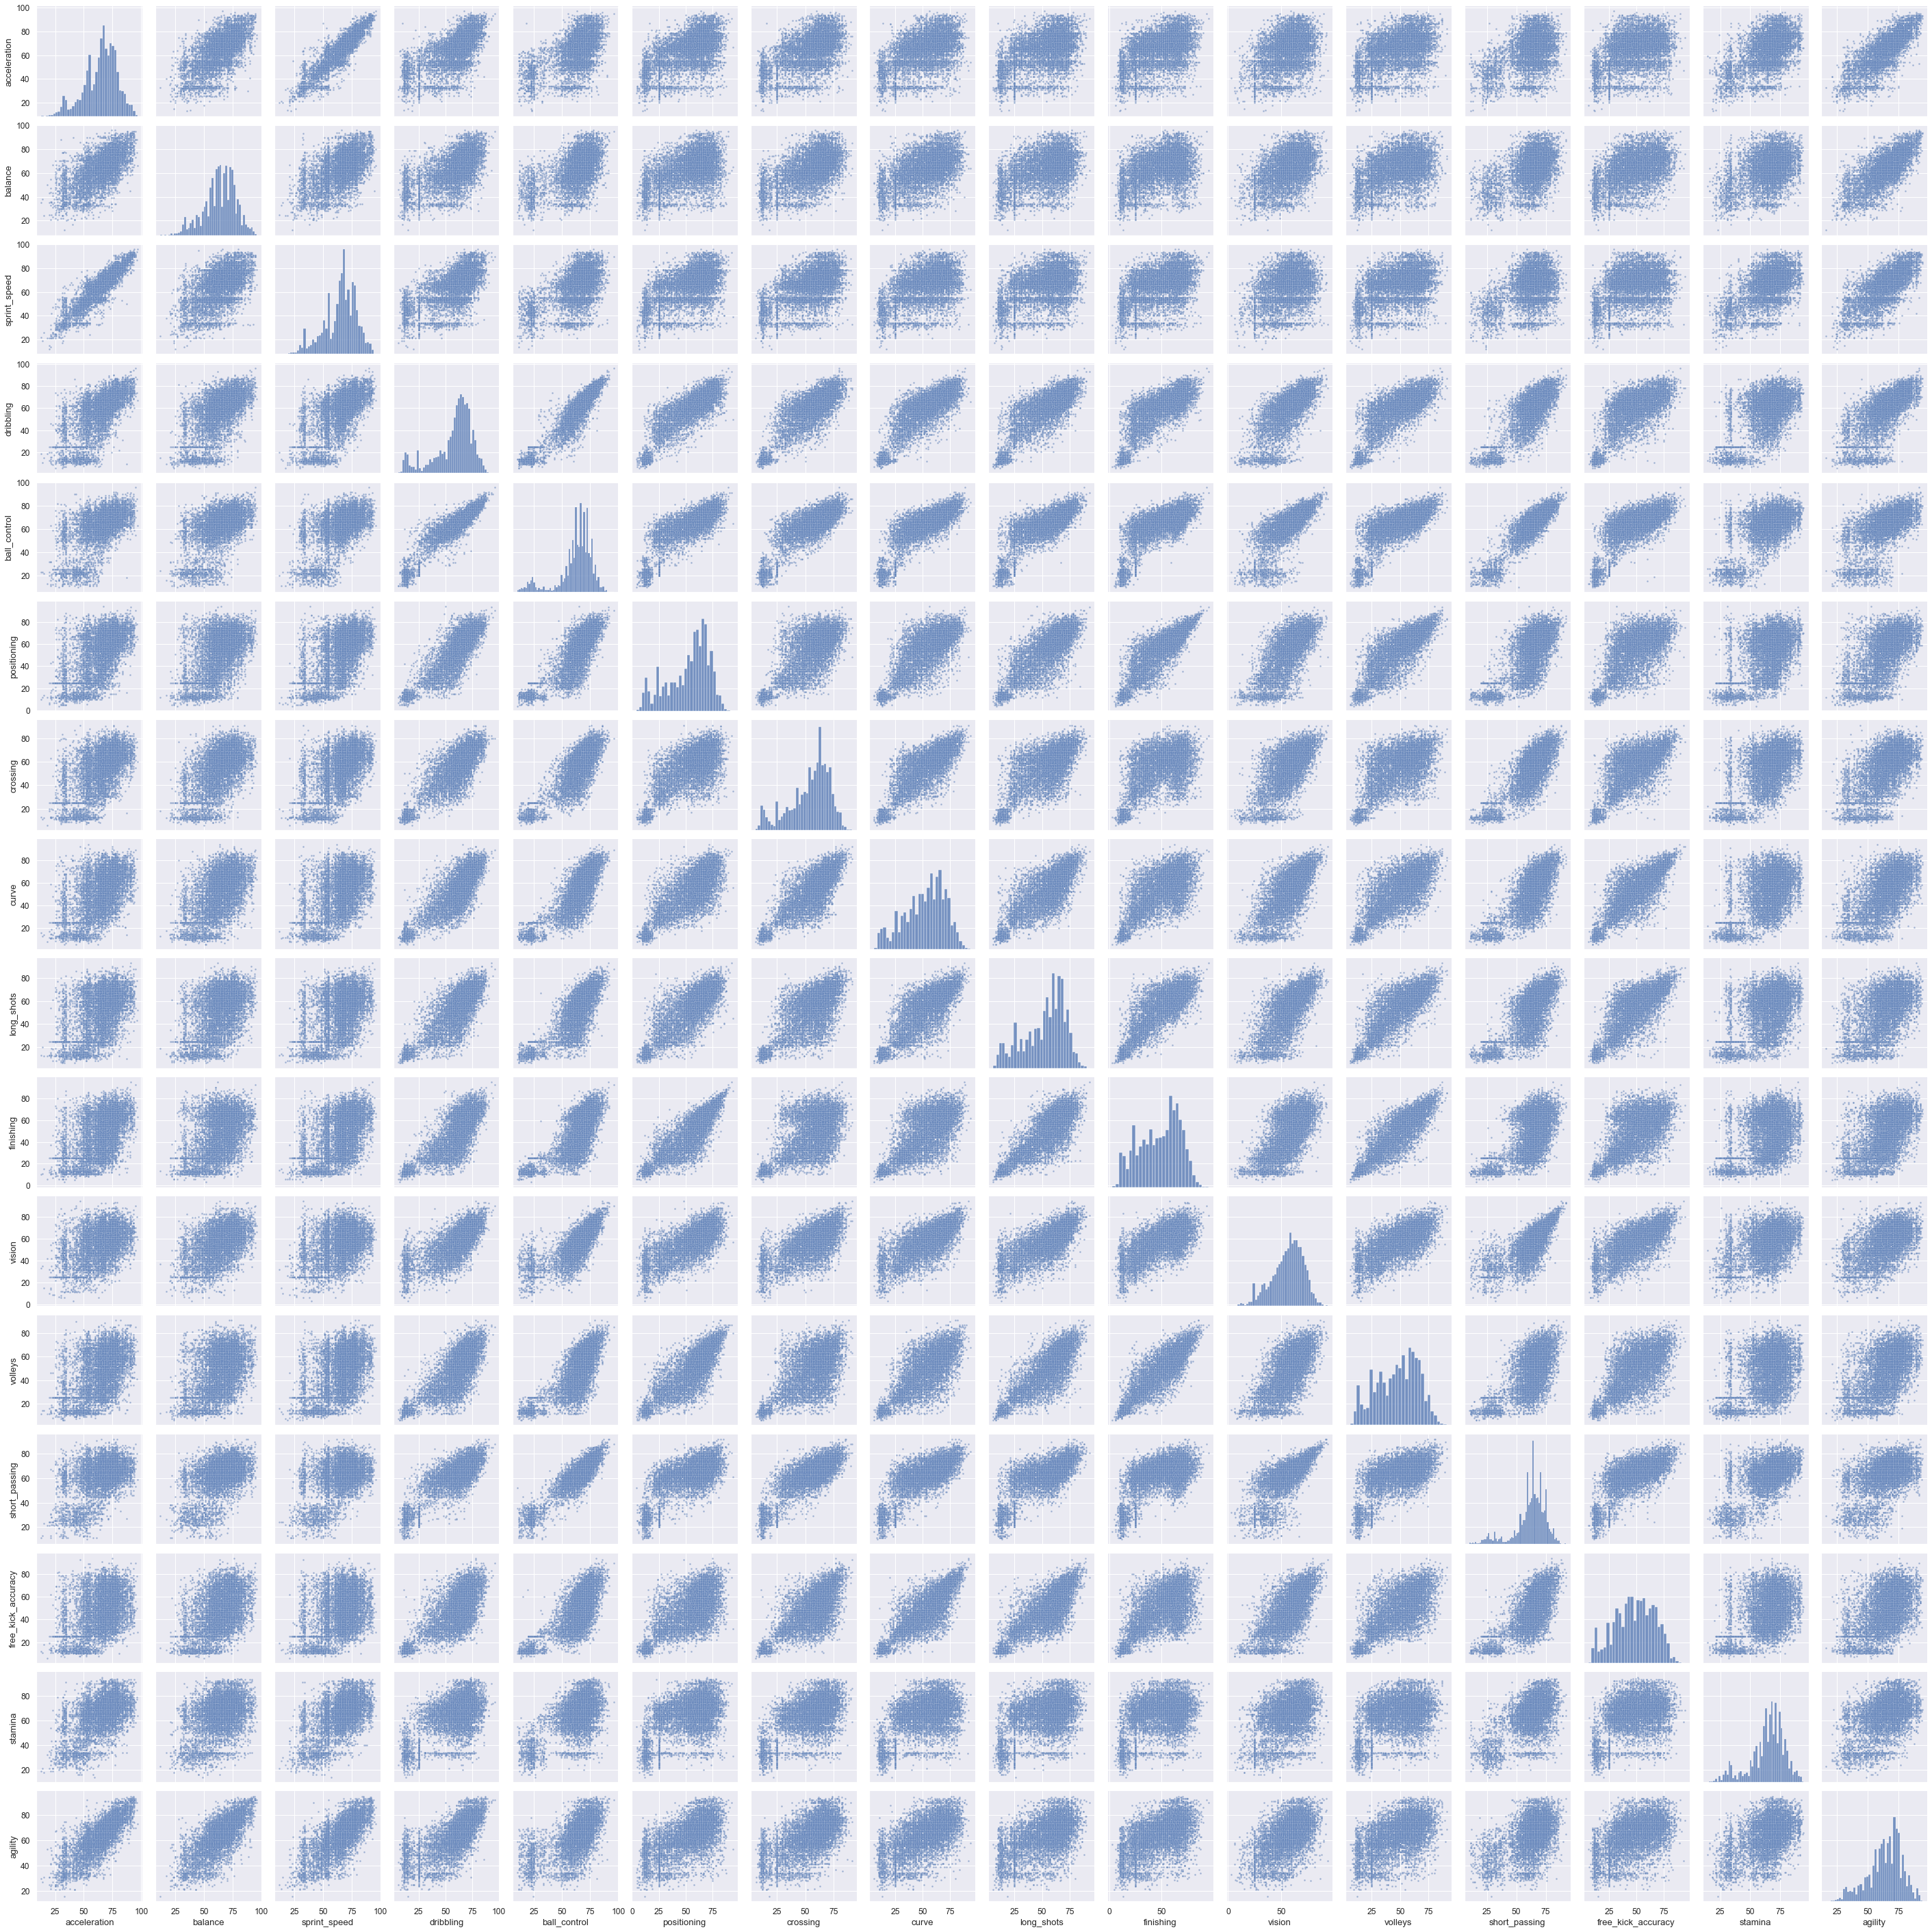

In [874]:
sns.pairplot(DF_TRAIN[cols], plot_kws={'s': 7, 'alpha': 0.5});

As we can see there are different pairwise correlations between features. There is a lot of info above to analyze but in general I can underline that many features have linear relationship with each other.

### Analyze if collinear/multicollinear features are present in your feature set.

Collinearity is bad because collinearity hinders the performance and accuracy of our regression model.

Let's use corr method for finding collinnearity between independent features. For the easier use, let's plot a heatmap only with half of values (because values in a heatmap are symmetrical and so are duplicated).

<AxesSubplot:>

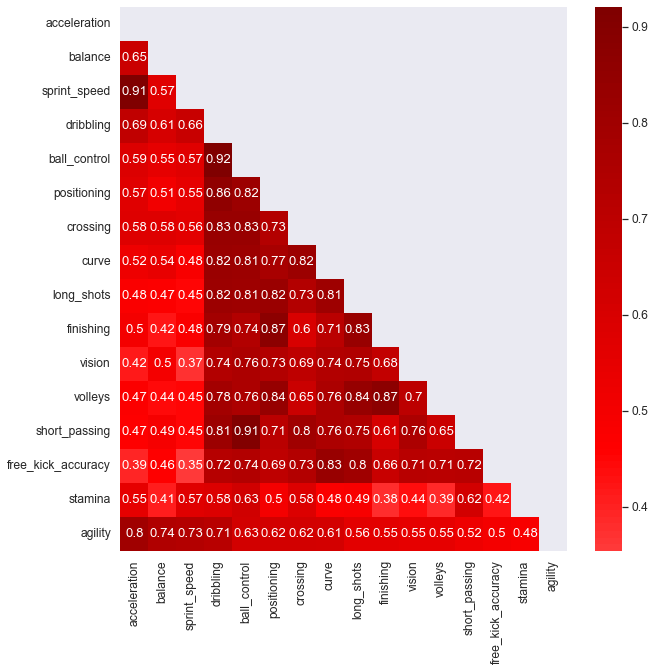

In [875]:
corralation_between_all = df[cols].corr()
plt.figure(figsize = (10,10))
matrix = np.triu(corralation_between_all)
sns.heatmap(corralation_between_all, center=0, cmap='seismic', annot=True, mask=matrix)

There is no certain border which if you crose the values becomes collinear, so we will define the border ourselves. Let's assume that everything that has correlation bigger than 0.7 is collinear. There are such values on the heatmap, however, we can miss some values if we will try to find them with our eyes.

Instead, let's transform correlation matrix, so we have 2 columns (names of features) and the third column - their correlation. Moreover, we will delete duplicates and sort our new matrix.

In [876]:
corralation_between_all = corralation_between_all[abs(corralation_between_all) >= 0.01].stack().reset_index()
corralation_between_all = corralation_between_all[corralation_between_all['level_0'].astype(str)!=corralation_between_all['level_1'].astype(str)]
 
# filtering out lower/upper triangular duplicates 
corralation_between_all['ordered-cols'] = corralation_between_all.apply(lambda x: '-'.join(sorted([x['level_0'],x['level_1']])),axis=1)
corralation_between_all = corralation_between_all.drop_duplicates(['ordered-cols'])
corralation_between_all.drop(['ordered-cols'], axis=1, inplace=True)
 
corralation_between_all.sort_values(by=[0], ascending=False).head(20)

level_0             level_1         0
52      dribbling        ball_control  0.920367
2    acceleration        sprint_speed  0.912161
76   ball_control       short_passing  0.905642
89    positioning           finishing  0.870469
155     finishing             volleys  0.870419
53      dribbling         positioning  0.857636
139    long_shots             volleys  0.836513
91    positioning             volleys  0.835576
54      dribbling            crossing  0.829761
125         curve  free_kick_accuracy  0.827755
70   ball_control            crossing  0.827153
137    long_shots           finishing  0.826329
55      dribbling               curve  0.822143
88    positioning          long_shots  0.820785
103      crossing               curve  0.817277
69   ball_control         positioning  0.816729
56      dribbling          long_shots  0.815342
60      dribbling       short_passing  0.812938
71   ball_control               curve  0.812113
72   ball_control          long_shots  0.808432

Now we see that there are lot's of collinear values in our dataset. Dribbling and ball_control, acceleration and sprint_speed and etc.

Let's provide an assumption of why some of those correlations might occur.

I will again use https://www.fifplay.com/encyclopedia/volley/ for explanations

1. Dribbling and ball_control. Ball control - the ability of a player to control the ball on the pitch. Dribbling determines a player's ability to carry the ball and past an opponent while being in control. These skills are very connected logically, it's about the movement of a players with a ball on the pitch.

2. Acceleration and sprint_speed. Acceleration - is about how quickly you can increase your speed. Sprint speed - speed with which a person runs. Acceleration is about speed and sprint speed is about speed, so they are conncted logically.

3. Ball control and short passing. Ball control - the ability of a player to control the ball on the pitch. Short passing is a player's accuracy for the short passes. May be they are logically connected because if you cannot control a ball than you will not be able to hit it properly in a short pass.

4. Posioning and finishing. Positioning is a player's ability to place themselves in the right position to receive/catch the ball, score goals or do a tactical move. Finishing determines the ability of a player to score. May be they are logically correlated because if you do not place yourselve in right position, than you have lower chances for scoring.

5. Finishing and volleys. Finishing determines the ability of a player to score. Volleys - ability to perform a kick of the ball made before it touches the ground. May be they are connected because if you can perform a volley, you can quicker kick it and so a gatekeeper will not defend on time.

Howerver, some of those and other collinearities might happen because of multicollinearities.

For example, I cannot provide logic for the correlation between dribbling and positioning, positioning and volleys and etc.

Let's take one more step to dive deeper into collinearity before we will try to fix something in it.

There is a slight difference between collinearity and multicollinearity: collinearity is between 2 values, multicollinearity is between more than 2 values.

**Multicollinearity**

Let's first find with our eyes some of the "chains" of multicollinearity.

1. Dribbling and ball_control. As I have said before they have a high connection with each other.

I marked with red the highest correlation between ball_control and other features and with green between dribbling and other features. We will use this data while processing multicollinear features.

!["Multicollinearity including dribbling and ball control"](chains_of_multicollinearity_dribbling_ball_control.png)

If we examine it futher we will see that there is a strong multicollinearity between dribbling, ball_control, long_shots, curve, volleys and may be some other values. Let's keep it in mind.

!['Going futher'](chains_of_multicollinearity_further.png)

If we continue finding multicolllinearity with our eyes, it will take us a lot of time.

There is a solution to that called VIF score (Variation Inflation Factor) which finds a correlation of a variable with a group of other variables.

- ViF 1 => No correlation

- VIF 1 to 5 => moderate correlation

- VIF > 10 High Correlation

Let's calculate VIF for our dataset.

In [877]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def vif_scores(df):
    VIF_Scores = pd.DataFrame()
    VIF_Scores["Independent Features"] = df.columns
    VIF_Scores["VIF Scores"] = [variance_inflation_factor(df.values,i) for i in range(df.shape[1])]
    return VIF_Scores.sort_values(by='VIF Scores', ascending=False)

calc_vif_1 = df[cols].iloc[:, :-1]
vif_scores(calc_vif_1)

Independent Features  VIF Scores
4          ball_control  228.303197
0          acceleration  162.057847
12        short_passing  144.268175
2          sprint_speed  142.638878
3             dribbling  121.284134
5           positioning   57.382350
8            long_shots   54.002125
9             finishing   50.673790
10               vision   50.396934
7                 curve   50.316492
6              crossing   49.976105
11              volleys   44.183244
1               balance   43.519255
14              stamina   42.883149
13   free_kick_accuracy   33.713377

As we can all of values have high multicollinearity, let's process it: **delete some values** and **combine others**.

1. Let's delete ball_control or dribbling since as we have discovered before they are high colleniar with each other and their collinearity can be explained logically. **_I delete ball_control because I tried deleting both of them while preparing this notebook and deliting ball control decreases VIF score more than deleting dribbling_**

In [878]:
target = 'agility'
features.remove('ball_control')
cols = features + [target]
calc_vif_2 = df[cols]
calc_vif_2 = calc_vif_2.iloc[:, :-1]
vif_scores(calc_vif_2)

Independent Features  VIF Scores
0          acceleration  161.845889
2          sprint_speed  142.245305
3             dribbling   94.615782
11        short_passing   86.414119
4           positioning   57.298847
7            long_shots   54.001690
8             finishing   50.501715
9                vision   50.396778
6                 curve   50.212542
5              crossing   49.971370
10              volleys   44.055018
1               balance   43.507808
13              stamina   42.148436
12   free_kick_accuracy   33.711016

As we can deletion of a ball_control decreased VIF scores of other values, for example, short_passing dropped from 144 to 86.

2. Let's try another way of dilling with collinearity - combine some features, for example, sprint_speed and acceleration since as we have seen before they are highly colinear with each other and their collinearity can be explained logically.

In [879]:
df['acceleration_and_sprint_speed'] = (df['sprint_speed'] + df['acceleration']) / 2
features.remove('sprint_speed')
features.remove('acceleration')
features.append('acceleration_and_sprint_speed')
cols = features + [target]
calc_vif_2 = df[cols]
calc_vif_2 = calc_vif_2.iloc[:, :-1]
vif_scores(calc_vif_2)

Independent Features  VIF Scores
1                       dribbling   93.868230
9                   short_passing   85.480031
2                     positioning   57.298325
12  acceleration_and_sprint_speed   56.865582
5                      long_shots   53.989759
6                       finishing   50.477885
7                          vision   50.323410
4                           curve   50.177009
3                        crossing   49.937893
8                         volleys   44.006581
11                        stamina   41.902026
0                         balance   41.765020
10             free_kick_accuracy   33.701967

As we can see it barely changed anything.

3. I don't see how we can logically combine other values, so let's just continue deleting values that are multicollinear.

As I found before multicollinear values are dribbling, ball_control, long_shots, curve, volleys. Also as I found before logically I cannot exaplin how long_shots can influence agility, so let's delete it. 

In [880]:
target = 'agility'
features.remove('long_shots')
cols = features + [target]
calc_vif_3 = df[cols]
calc_vif_3 = calc_vif_3.iloc[:, :-1]
vif_scores(calc_vif_3)

Independent Features  VIF Scores
1                       dribbling   93.215203
8                   short_passing   84.880281
2                     positioning   57.228493
11  acceleration_and_sprint_speed   56.292565
6                          vision   50.200225
4                           curve   49.931330
3                        crossing   49.876211
5                       finishing   47.006127
7                         volleys   42.254688
0                         balance   41.697826
10                        stamina   41.537656
9              free_kick_accuracy   30.979998

In [881]:
target = 'agility'
features.remove('short_passing')
cols = features + [target]
calc_vif_3 = df[cols]
calc_vif_3 = calc_vif_3.iloc[:, :-1]
vif_scores(calc_vif_3)

Independent Features  VIF Scores
1                       dribbling   87.182145
2                     positioning   56.833815
10  acceleration_and_sprint_speed   55.916940
4                           curve   49.923530
3                        crossing   48.197312
5                       finishing   46.847102
7                         volleys   42.220646
0                         balance   41.350704
6                          vision   40.959523
9                         stamina   33.432376
8              free_kick_accuracy   30.667746

In [882]:
target = 'agility'
features.remove('positioning')
cols = features + [target]
calc_vif_3 = df[cols]
calc_vif_3 = calc_vif_3.iloc[:, :-1]
vif_scores(calc_vif_3)

Independent Features  VIF Scores
1                      dribbling   81.459661
9  acceleration_and_sprint_speed   55.888837
3                          curve   49.748340
2                       crossing   47.576306
6                        volleys   41.491844
0                        balance   41.236849
5                         vision   40.579229
4                      finishing   37.613853
8                        stamina   33.340283
7             free_kick_accuracy   30.533178

### Fit the model

Before we have already fitted our model to check how we deal with collinearity. Now it is a final fit for our final model.

Let's fit our model, for that let's define DF_TRAIN, DF_TEST, x_train and etc. again because we added a column to our initial dataset df and deleted some columns from features array.

In [883]:
print(df.shape)
ix_split = int(0.7 * df.shape[0])
DF_TRAIN = df.iloc[:ix_split].copy()
DF_TEST = df.iloc[ix_split:].copy()
print(DF_TRAIN.shape, DF_TEST.shape)
x_train, y_train, x_test, y_test = get_train_test_data(features, target)

(10582, 36)
(7407, 36) (3175, 36)


Let's calculate metrics on train and test data.

In [884]:
lr_matrix_form = LRMatrixForm(fit_intercept=False)
fit_and_evaluate(lr_matrix_form, x_train, y_train, x_test, y_test)

mse       mae      mape        r2
train  47.011197  5.215150  0.092609  0.749249
test   51.434095  5.388148  0.096715  0.739304

### Analyze fitted model perfomance

### Print fitted model parameters and calculate their  𝐿2 -norm value

Let's print fitted model parameters.

In [885]:
print(f'intercept: {lr_matrix_form.intercept_}')
print(f'coef: {lr_matrix_form.coef_}')

intercept: 0.0
coef: [ 0.35327942  0.06649657 -0.05837589  0.07044704  0.00467726  0.1147219
  0.00316506 -0.00340319 -0.01682023  0.48688842]


As stated in one of other tasks we performed, big coeffitiens can show that a model is overfitted. However, coeffitiens of my model are not big (they are all less beetween -1 and 1) which let's us assume that it is not overfitted.

Let's calculare their L2 norm value.

In [886]:
l2_norm(lr_matrix_form.coef_)

0.623014061148889

L2 is less than 1 which is small and let's us assume that the model is not overfitted.

In addition to requirements in the task, let's calculate the determinant.

In [887]:
np.linalg.det(df[features].corr(method='pearson'))

8.126602840419881e-05

According to 
http://www.machinelearning.ru/wiki/index.php?title=%D0%9C%D1%83%D0%BB%D1%8C%D1%82%D0%B8%D0%BA%D0%BE%D0%BB%D0%BB%D0%B8%D0%BD%D0%B5%D0%B0%D1%80%D0%BD%D0%BE%D1%81%D1%82%D1%8C,
    multicollinearity can be shown by a determinant that is close to 0. As seen above, our determinant is 0.0008 which is not exactly 0.

### Is my model overfitted?

I make a conclusion that our model is more likely to be **NOT overfitted** because:
1. Coefficients are low (less than 1)
2. L2 is small (less than 1)
3. Determinant is not 0
4. As stated in one of the tasks "The best regression models are those in which the predictor variables each correlate highly with the target variable, but correlate at most only minimally with each other."
Let's see the accuracy of this statement in our case based on graphs below.

Let's make a graph of correlation between agility and features we have left.

<AxesSubplot:>

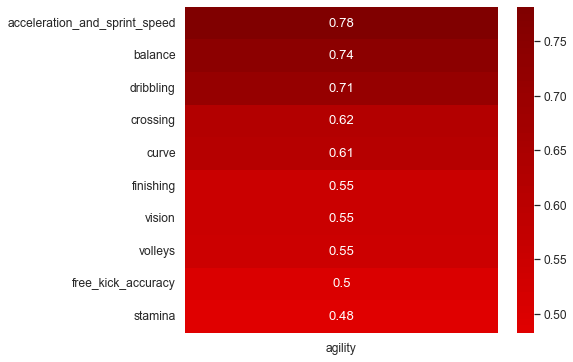

In [897]:
correlation_matrix = df[cols].corr()
correlation_matrix_with_agility = correlation_matrix[['agility']]
corr_matrix_with_agility_sorted = correlation_matrix_with_agility.sort_values(by=['agility'], ascending=False)
corr_matrix_with_agility_sorted = corr_matrix_with_agility_sorted.drop('agility')
sns.heatmap(corr_matrix_with_agility_sorted, center=0, cmap='seismic', annot=True)

As wee see remaining features correlate highly with Agility. Of course, there were features that correlated more with Agility than those that we have here but we had to delete them because of collineatiry and multicollinearity.

Let's make  a graph of correlations between features that we have left.

<AxesSubplot:>

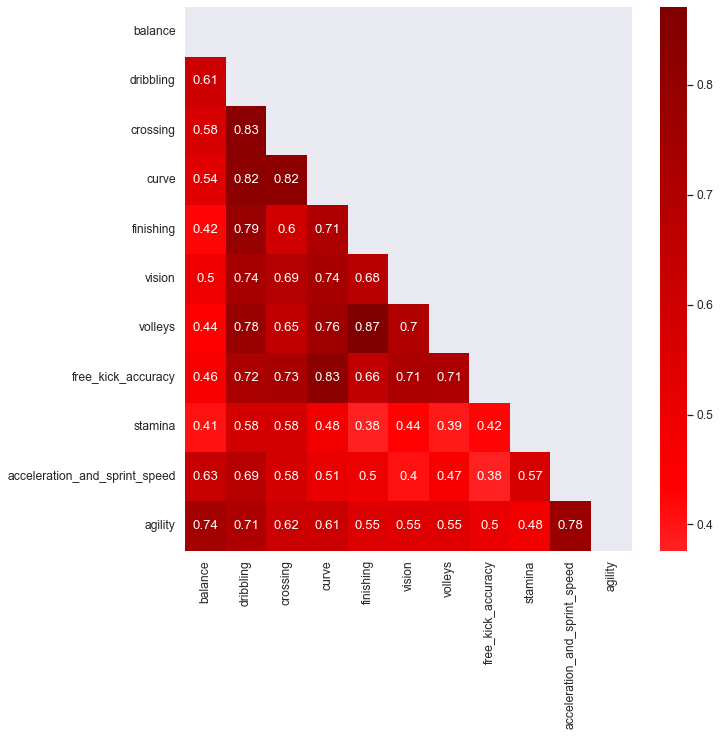

In [896]:
corralation_between_all = df[cols].corr()
plt.figure(figsize = (10,10))
matrix = np.triu(corralation_between_all)
sns.heatmap(corralation_between_all, center=0, cmap='seismic', annot=True, mask=matrix)

As seen above, there are no features that have correlation close to 1.

To conclude, **the model is NOT overfitted**.

### Short report about the work done

**Can you find a logical explanation for high correlation of some of your features?**

**_I am copying here an explanation that I already had in some part of my notebook_**

**Are you satisfied with the quality of predictions?**
I tried my best to understand how linear regression works, find multicollinerity (I even used the VIF score which wasn't presented earlier in the task), delete and combine features. To conclude, I am satisfied with the quality if we talk about it as a prototype model. Of course, I would love to improve the quality of predictions using the knowledge that I will gain in the Overfitting section of the course.

**How could you pottentially improve the model?**

1. We could take into consideration other initial features that have correlation with agility
2. We could try to "play" with multicollinear features, may be delete or combine other features from those that we deleted and combined, calculate model metrics and L2 and see which ones are better to delete and combine.
3. Try Regularization (as stated in the task it will be explain on other weeks of our training)
4. If none of this satisfies our expectations of model accuracy, we could change our model to another one, for example, to Ridge regression

Another thoughts:

In this work I went through steps of writing a linear regression model manually:

    - in Task 1 I kept the latest data for each player in the dataset
    - in Task 2 Dropped rows that contain NaNs
    - in Task 3 implemented main regression metrics (MSE, MAE, MAPE, R2) myself and covered the cases when MAPE takes 0 in labels into accout and R2 takes possible 0 in numerator and denumerator
    - in Task 4 Computed Pearson correlation coefficient between feature and target
    - in Task 5 Calculated predictions Simple Linear Regression for test set manually
    - in Task 6 Plotted data we had and predicted values we got
    - in Task 7 Fitted simple linear regression model manually
    - in Task 8 Built pairwise correlation matrix for selected features and target, visuzliaed it with a heatmap
    - in Task 9 Implemented Linear Regression model with multimaple variables myself
    - in Task 10 Implemented function to calculate L2-norm
    - in Task 11 Visualized correlation matrix for x_train
    - in Task 12 Built a Linear regression model to be used to predict "Agility" variable using functions I already made in previous steps